In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 947
__N_FOLDS = 3
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import impute

import ml_utils as mutils
import time, datetime, pickle

font = {'size'   : 13}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mutils.seed_everything(__SEED)

fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)

sys.stderr = open('/dev/stdout', 'w')
sys.stderr = sys.__stderr__

In [2]:
train = pd.read_csv("train.csv", index_col="id")
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [3]:
test = pd.read_csv("test.csv", index_col="id")
test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,52f6dd16c,147d704e4,8d857a0a1,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,691ebeae8,8653dcc2e,67a8d4ebb,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,81f792c16,6cdda499e,69403e18c,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,c9134205b,acbca4827,cb681246b,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,f0f100f57,6f800b9af,cd9feb5c6,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


<Figure size 432x288 with 0 Axes>

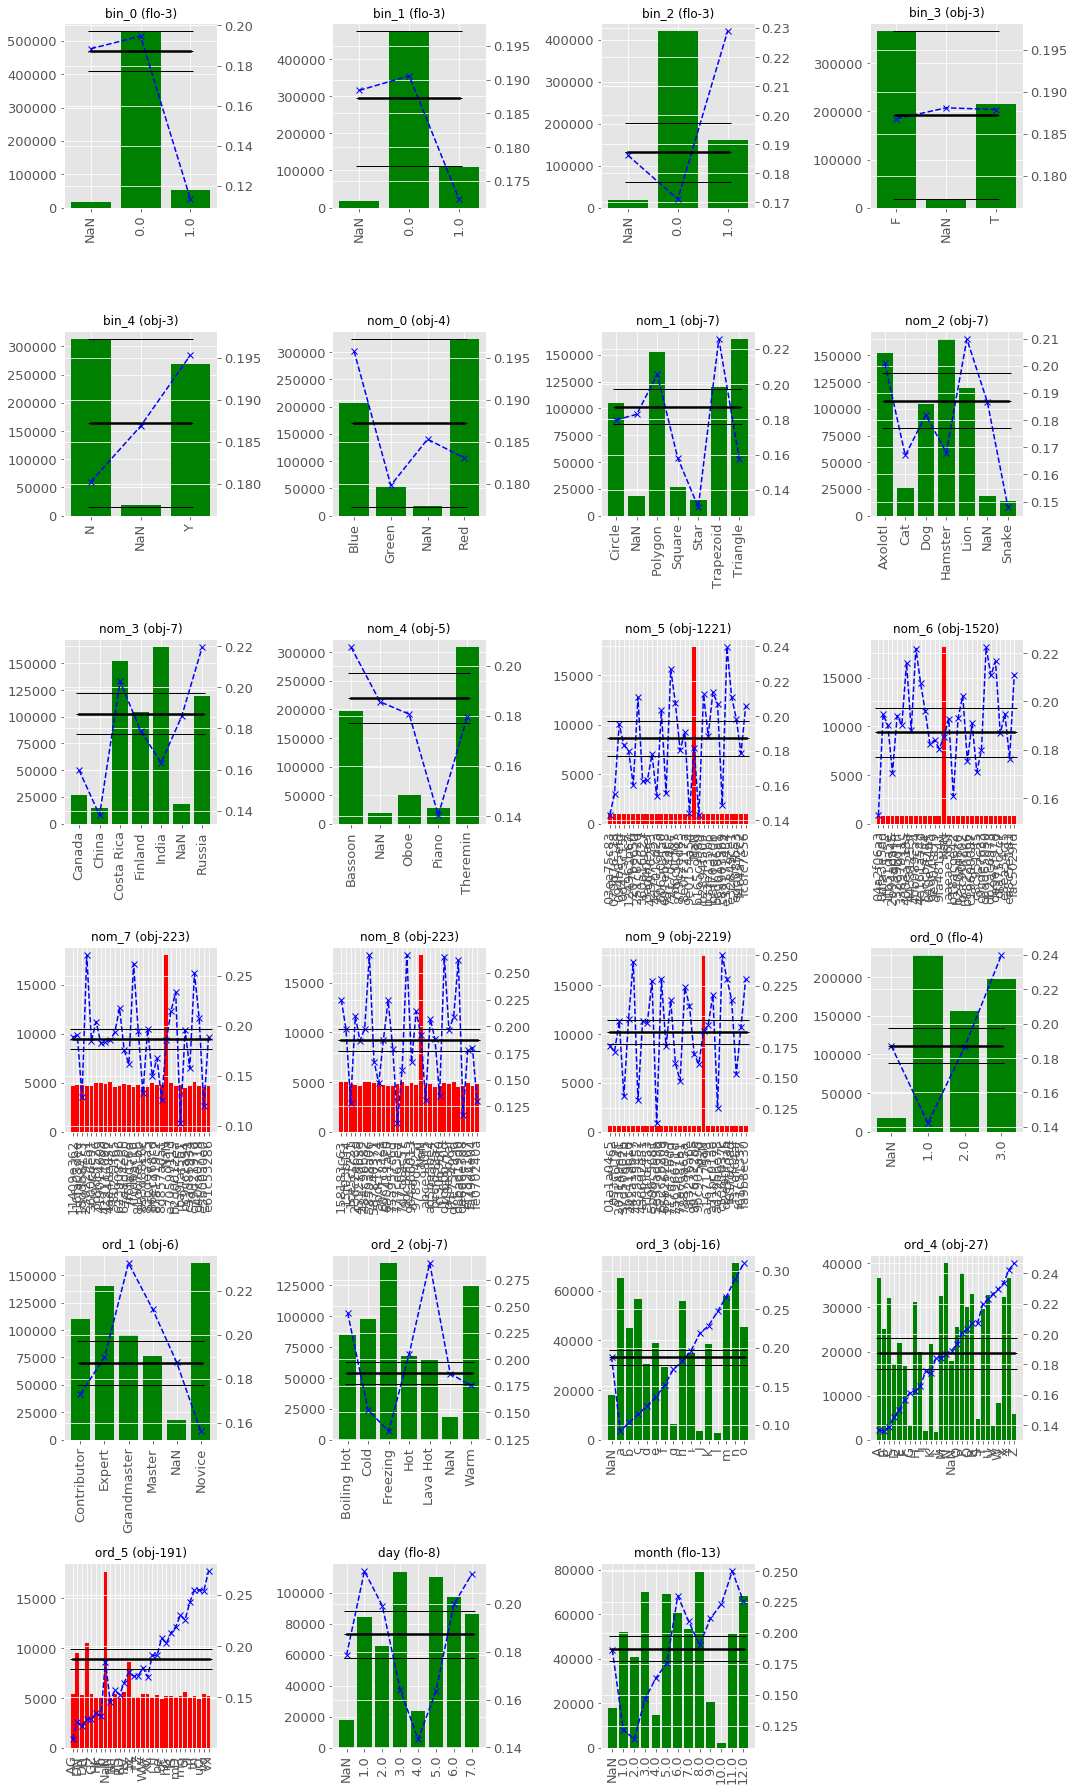

In [4]:
mutils.plot_multiple_categorical(train, [f for f in train.columns if f!="target"], col_target="target", top_n=30)

In [5]:
stat,_,_ = mutils.summarize_categorical(train, test, exclude_feat=["target"], target_for_cramerV="target")
stat

,Feature,Target Cramer's V,Unique values (Train),Unique values (Test),Train only value counts,Test only value counts,Missing (Train),Missing (Test),Value with the highest counts (Train),DataType
0,bin_0,0.060,2,2,0(0.0),0(0.0),17894(2.982),17894(2.982),0.0(88.063),float64
1,bin_1,0.018,2,2,0(0.0),0(0.0),18003(3.0),18003(3.0),0.0(79.003),float64
2,bin_2,0.066,2,2,0(0.0),0(0.0),17930(2.988),17930(2.988),0.0(69.974),float64
3,bin_3,0.001,2,2,0(0.0),0(0.0),18014(3.002),18014(3.002),F(61.035),object
4,bin_4,0.019,2,2,0(0.0),0(0.0),18047(3.008),18047(3.008),N(52.057),object
5,nom_0,0.016,3,3,0(0.0),0(0.0),18252(3.042),18252(3.042),Red(53.881),object
6,nom_1,0.071,6,6,0(0.0),0(0.0),18156(3.026),18156(3.026),Triangle(27.365),object
7,nom_2,0.046,6,6,0(0.0),0(0.0),18035(3.006),18035(3.006),Hamster(27.483),object
8,nom_3,0.060,6,6,0(0.0),0(0.0),18121(3.02),18121(3.02),India(27.478),object
9,nom_4,0.042,4,4,0(0.0),0(0.0),18035(3.006),18035(3.006),Theremin(51.437),object


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import category_encoders as ce

lr_params = {
    "solver":"lbfgs",
    "penalty":"l2",
    "max_iter":2222,
    "verbose":1,
    "n_jobs":5,
    "random_state":__SEED,
    "C":0.5678
}
xgbc_params = {
    'learning_rate': 0.2,
    'n_estimators': 123, 
    'objective': 'binary:logistic',
    'max_depth': 5,
    'min_child_weight':3,
    'grow_policy':'lossguide',
    'verbose':2
}


In [18]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.le_={}
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        df = X.copy()
        for i, col in enumerate(self.columns):
            le = pp.LabelEncoder()
            self.le_[col] = le
            df[col] = le.fit_transform(df[col].astype(str))
        return df


class CustomMostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.mode = None
    def fit(self, X, y=None):
        self.mode = X[self.columns].mode().values[0]
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
            df[col].fillna(self.mode[i],inplace=True)
        return df

class CustomMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.median = None
    def fit(self, X, y=None):
        self.median = X[self.columns].median().values
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
            df[col].fillna(self.median[i],inplace=True)
        return df

class CustomNewCategoryImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for i, col in enumerate(self.columns):
            df[col].fillna("NoData",inplace=True)
            df[col] = df[col].astype(str)
        return df

class CrossValTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cv):
        self.transformer = transformer
        self.cv = cv
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    def transform(self, X, y=None):
        df = X.copy()
        df = self.transformer.transform(X, y)
        return df
    def get_oof_transform(self, X, y):
        oof = pd.DataFrame(index=X.index, columns=X.columns)
        for train_idx, valid_idx in self.cv.split(X,y):
            train_X = X.loc[train_idx]
            train_y = y.loc[train_idx]
            valid_X = X.loc[valid_idx]
            valid_y = y.loc[valid_idx]
            
            self.transformer.fit(train_X, train_y)
            oof_txf = self.transformer.transform(valid_X)
            
            oof.loc[valid_idx] = oof_txf
        return oof

In [19]:
def cross_val_train(model, X_train, y_train, cv, score_function, best_score, 
                    feat1, txf1, verbose=False):
    
    if verbose:
        print("Preprocessing....")
    start_time = time.time()
    # Preprocessing pipe
    preprocessed_x_1 = txf1.fit_transform(X_train[feat1], y_train)
#     preprocessed_x_2 = txf2.fit_transform(X_train[feat2], y_train)
#     preprocessed_x_3 = txf3.get_oof_transform(X_train[feat3], y_train).astype("float")
    
    # merge preprocessed
    PPX_train = scipy.sparse.hstack([preprocessed_x_1]).tocsr()
    
    
    if verbose:
        print("Preprocessing....Done -- Time Taken: {}".format(datetime.timedelta(seconds=time.time()-start_time)))
    
    valid_scores = []
    train_scores = []
    
    for i, (train_idx, valid_idx) in enumerate(cv.split(PPX_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = PPX_train[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = PPX_train[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y)
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
    return cv_score

In [20]:
bf = ["bin_"+str(i) for i in range(5)]
nf = ["nom_"+str(i) for i in range(10)]
of = ["ord_"+str(i) for i in range(6)]
tf = ["day", "month"]
all_features = bf+nf+of+tf


X_train = train[all_features]
y_train = train["target"]

In [6]:
BaseLine = pd.DataFrame()

In [14]:
%%time
## ALL OHE, MF Imputation
all_features = bf+nf+of+tf

imputer = CustomMostFrequentImputer(all_features)
ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), all_features)

f1 = all_features
txf1 = make_pipeline(imputer, make_column_transformer(ohe))

# lrb1 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,0, f1, txf1, verbose=False)
# lrb2 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,0, f1, txf1, verbose=False)
# lrb3 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score,0, f1, txf1, verbose=False)

xgb1 = cross_val_train(XGBClassifier(**xgbc_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,0, f1, txf1, verbose=False)
xgb2 = cross_val_train(XGBClassifier(**xgbc_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,0, f1, txf1, verbose=False)
xgb3 = cross_val_train(XGBClassifier(**xgbc_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score,0, f1, txf1, verbose=False)

# BaseLine.loc["LRB-MFI-OH","cv1"] = lrb1
# BaseLine.loc["LRB-MFI-OH","cv2"] = lrb2
# BaseLine.loc["LRB-MFI-OH","cv3"] = lrb3
# BaseLine.loc["LRB-MFI-OH", "avg"] = (lrb1+lrb2+lrb3)/3.0

# BaseLine.loc["XGB-MFI-OH","cv1"] = xgb1
# BaseLine.loc["XGB-MFI-OH","cv2"] = xgb2
# BaseLine.loc["XGB-MFI-OH","cv3"] = xgb3
# BaseLine.loc["XGB-MFI-OH", "avg"] = (xgb1+xgb2+xgb3)/3.0

KeyboardInterrupt: 

In [23]:
%%time
## ALL OHE, Constant Imputation
all_features = bf+nf+of+tf

imputer = CustomNewCategoryImputer(all_features)
ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), all_features)

f1 = all_features
txf1 = make_pipeline(imputer, make_column_transformer(ohe))

# lrb1 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,0, f1, txf1, verbose=False)
# lrb2 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,0, f1, txf1, verbose=False)
# lrb3 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score,0, f1, txf1, verbose=False)

xgb1 = cross_val_train(XGBClassifier(**xgbc_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,0, f1, txf1, verbose=True)
xgb2 = cross_val_train(XGBClassifier(**xgbc_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,0, f1, txf1, verbose=False)
xgb3 = cross_val_train(XGBClassifier(**xgbc_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score,0, f1, txf1, verbose=False)

# BaseLine.loc["LRB-CI-OH","cv1"] = lrb1
# BaseLine.loc["LRB-CI-OH","cv2"] = lrb2
# BaseLine.loc["LRB-CI-OH","cv3"] = lrb3
# BaseLine.loc["LRB-CI-OH", "avg"] = (lrb1+lrb2+lrb3)/3.0


# BaseLine.loc["XGB-CI-OH","cv1"] = xgb1
# BaseLine.loc["XGB-CI-OH","cv2"] = xgb2
# BaseLine.loc["XGB-CI-OH","cv3"] = xgb3
# BaseLine.loc["XGB-CI-OH", "avg"] = (xgb1+xgb2+xgb3)/3.0

Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:06.028970
Training....Fold 1
Fold 1 train score: 0.77357
Fold 1 valid score: 0.75877
Training....Fold 2


KeyboardInterrupt: 

In [84]:
# mutils.save_experiments(BaseLine, "BaseLine-CI-MFI-OH")

In [8]:
BaseLine = pd.read_csv("BaseLine-CI-MFI-OH_EXPERIMENTS.csv", index_col=0)

In [9]:
BaseLine

,cv1,cv2,cv3,avg
LRB-MFI-OH,0.781926,0.781550,0.782176,0.781884
XGB-MFI-OH,0.765946,0.765317,0.765929,0.765731
LRB-CI-OH,0.784842,0.784497,0.785158,0.784833
XGB-CI-OH,0.768737,0.768410,0.768900,0.768682


## Explore Binary Variables

In [128]:
Bin_BaseLines = pd.DataFrame()

In [129]:
# drop results

all_features = bf+of+nf+tf

for f in bf:
    for imp in ["CI", "MFI"]:
        print("Dropped: {} -- {}".format(f, imp))
        tmp_f = list(set(all_features)-{f})
        
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tmp_f)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tmp_f)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tmp_f)

        f1 = tmp_f
        txf1 = make_pipeline(imputer, make_column_transformer(ohe))

        r1 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,base1, f1, txf1, verbose=False)
        r2 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,base2, f1, txf1, verbose=False)
        Bin_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "score1"] = r1
        Bin_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "diff1"] = r1 -base1
        Bin_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "score2"] = r2
        Bin_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "diff2"] = r2 -base2

Dropped: bin_0 -- CI
↓CV valid score: 0.7812171 - Previous best score: 0.7848424 - Train score: 0.799998 - Time 0:01:39.403522
↓CV valid score: 0.7808639 - Previous best score: 0.7844974 - Train score: 0.800070 - Time 0:01:41.795315
Dropped: bin_0 -- MFI
↓CV valid score: 0.7782492 - Previous best score: 0.7819264 - Train score: 0.797209 - Time 0:01:44.514585
↓CV valid score: 0.7778735 - Previous best score: 0.7815498 - Train score: 0.797272 - Time 0:01:37.964204
Dropped: bin_1 -- CI
↓CV valid score: 0.7844828 - Previous best score: 0.7848424 - Train score: 0.803014 - Time 0:01:44.997256
↓CV valid score: 0.7841304 - Previous best score: 0.7844974 - Train score: 0.803090 - Time 0:01:45.989697
Dropped: bin_1 -- MFI
↓CV valid score: 0.7815467 - Previous best score: 0.7819264 - Train score: 0.800250 - Time 0:01:43.161910
↓CV valid score: 0.7811716 - Previous best score: 0.7815498 - Train score: 0.800322 - Time 0:01:39.854336
Dropped: bin_2 -- CI
↓CV valid score: 0.7810013 - Previous best sc

In [130]:
def constant_fill(srs, val):
    tmp = srs.copy()
    return tmp.fillna(val)

In [131]:
def cross_val_train_2(model, X_train, y_train, cv, score_function, best_score, 
                    feat1, txf1, feat2, txf2, verbose=False):
    
    if verbose:
        print("Preprocessing....")
    start_time = time.time()
    # Preprocessing pipe
    preprocessed_x_1 = txf1.fit_transform(X_train[feat1], y_train)
    scl = pp.MinMaxScaler(copy=False)
    preprocessed_x_2 = scl.fit_transform(txf2(X_train[feat2], -1.0))
#     preprocessed_x_3 = txf3.get_oof_transform(X_train[feat3], y_train).astype("float")
    
    # merge preprocessed
    PPX_train = scipy.sparse.hstack([preprocessed_x_1, preprocessed_x_2]).tocsr()
    
    
    if verbose:
        print("Preprocessing....Done -- Time Taken: {}".format(datetime.timedelta(seconds=time.time()-start_time)))
    
    valid_scores = []
    train_scores = []
    
    for i, (train_idx, valid_idx) in enumerate(cv.split(PPX_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = PPX_train[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = PPX_train[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y)
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
    return cv_score

In [132]:

X_train_now = X_train.copy()
X_train_now["bin_3"] = X_train_now["bin_3"].map({"F":0,"T":1})
X_train_now["bin_4"] = X_train_now["bin_4"].map({"N":0,"Y":1})

In [133]:
# Treating Bin as numeric variables
all_features = bf+of+nf+tf

for f in bf:
    for imp in ["CI", "MFI"]:
        print("{} is numeric -- {}".format(f, imp))
        tmp_f = list(set(all_features)-{f})
        
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tmp_f)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tmp_f)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tmp_f)

        f1 = tmp_f
        txf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        r1 = cross_val_train_2(LogisticRegression(**lr_params), X_train_now.copy(), y_train.copy(), fold1, metrics.roc_auc_score, base1, f1, txf1,[f], constant_fill, verbose=False)
        r2 = cross_val_train_2(LogisticRegression(**lr_params), X_train_now.copy(), y_train.copy(), fold2, metrics.roc_auc_score, base2, f1, txf1,[f], constant_fill, verbose=False)
        
        Bin_BaseLines.loc["{} numeric --{}".format(f, imp), "score1"] = r1
        Bin_BaseLines.loc["{} numeric --{}".format(f, imp), "diff1"] = r1 -base1
        Bin_BaseLines.loc["{} numeric --{}".format(f, imp), "score2"] = r2
        Bin_BaseLines.loc["{} numeric --{}".format(f, imp), "diff2"] = r2 -base2


bin_0 is numeric -- CI
↓CV valid score: 0.7837001 - Previous best score: 0.7848424 - Train score: 0.802297 - Time 0:01:42.299407
↓CV valid score: 0.7833446 - Previous best score: 0.7844974 - Train score: 0.802373 - Time 0:01:39.633300
bin_0 is numeric -- MFI
↓CV valid score: 0.7807595 - Previous best score: 0.7819264 - Train score: 0.799524 - Time 0:01:38.143243
↓CV valid score: 0.7803672 - Previous best score: 0.7815498 - Train score: 0.799598 - Time 0:01:36.890166
bin_1 is numeric -- CI
↓CV valid score: 0.7847675 - Previous best score: 0.7848424 - Train score: 0.803289 - Time 0:01:44.347426
↓CV valid score: 0.7844213 - Previous best score: 0.7844974 - Train score: 0.803365 - Time 0:01:49.004240
bin_1 is numeric -- MFI
↓CV valid score: 0.7818422 - Previous best score: 0.7819264 - Train score: 0.800533 - Time 0:01:47.572784
↓CV valid score: 0.7814698 - Previous best score: 0.7815498 - Train score: 0.800606 - Time 0:01:48.134353
bin_2 is numeric -- CI
↓CV valid score: 0.7841869 - Previo

In [17]:
def cross_val_train_3(model, X_train, y_train, cv, score_function, best_score, 
                    feat1, txf1, feat2, txf2, txf22, verbose=False):
    
    if verbose:
        print("Preprocessing....")
    start_time = time.time()
    # Preprocessing pipe
    preprocessed_x_1 = txf1.fit_transform(X_train[feat1], y_train)
    
    preprocessed_x_2 = txf2.fit_transform(X_train[feat2], y_train)
    preprocessed_x_2 = txf22.get_oof_transform(preprocessed_x_2, y_train).astype("float")
#     preprocessed_x_3 = txf3.get_oof_transform(X_train[feat3], y_train).astype("float")
    
    # merge preprocessed
    PPX_train = scipy.sparse.hstack([preprocessed_x_1, preprocessed_x_2]).tocsr()
    
    
    if verbose:
        print("Preprocessing....Done -- Time Taken: {}".format(datetime.timedelta(seconds=time.time()-start_time)))
    
    valid_scores = []
    train_scores = []
    
    for i, (train_idx, valid_idx) in enumerate(cv.split(PPX_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = PPX_train[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = PPX_train[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y)
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
    return cv_score

In [143]:
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in list(set(bf)-{"bin_0","bin_1","bin_2"})[::-1]:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["MFI","CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            if(f=="bin_3" and di==True):
                continue
            print("{} is WOE--DI--{} -- {}".format(f,di,imp))
            woe = ce.WOEEncoder(cols=tf2, drop_invariant=di, regularization=0.25, random_state=__SEED)
            pipe_tf2 = CrossValTransformer(woe, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                   base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                   base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            
            Bin_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Bin_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Bin_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Bin_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

bin_3 is WOE--DI--False -- MFI
↑CV valid score: 0.7819333 - Previous best score: 0.7819264 - Train score: 0.800601 - Time 0:01:52.192907
↑CV valid score: 0.7815519 - Previous best score: 0.7815498 - Train score: 0.800672 - Time 0:01:41.307525
bin_3 is WOE--DI--False -- CI
↑CV valid score: 0.7848568 - Previous best score: 0.7848424 - Train score: 0.803358 - Time 0:01:53.620668
↑CV valid score: 0.7845097 - Previous best score: 0.7844974 - Train score: 0.803436 - Time 0:01:44.532596
bin_4 is WOE--DI--True -- MFI
↓CV valid score: 0.7819219 - Previous best score: 0.7819264 - Train score: 0.800603 - Time 0:01:51.426115
↓CV valid score: 0.7815426 - Previous best score: 0.7815498 - Train score: 0.800676 - Time 0:01:53.689794
bin_4 is WOE--DI--False -- MFI
↓CV valid score: 0.7819219 - Previous best score: 0.7819264 - Train score: 0.800603 - Time 0:01:51.006232
↓CV valid score: 0.7815426 - Previous best score: 0.7815498 - Train score: 0.800676 - Time 0:01:53.982000
bin_4 is WOE--DI--True -- CI
↑

In [147]:
all_features = bf+nf+of+tf

for f in bf:
    if f=="bin_0":
        continue
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["MFI","CI"]:
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            
            
                print("{} is LOO--DI--{} -- {}".format(f,di,imp))
                loo = ce.LeaveOneOutEncoder(random_state=__SEED, cols=tf2, drop_invariant=di)
                pipe_tf2 = CrossValTransformer(loo, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except:
                r1 = -10000
                r2 = -10000
            Bin_BaseLines.loc["{}--LOO--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Bin_BaseLines.loc["{}--LOO--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Bin_BaseLines.loc["{}--LOO--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Bin_BaseLines.loc["{}--LOO--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2

bin_1 is LOO--DI--True -- MFI
bin_1 is LOO--DI--False -- MFI
↓CV valid score: 0.7818326 - Previous best score: 0.7819264 - Train score: 0.800529 - Time 0:02:34.759954
↓CV valid score: 0.7814567 - Previous best score: 0.7815498 - Train score: 0.800604 - Time 0:02:08.645285
bin_1 is LOO--DI--True -- CI
bin_1 is LOO--DI--False -- CI
↓CV valid score: 0.7847604 - Previous best score: 0.7848424 - Train score: 0.803285 - Time 0:02:34.389977
↓CV valid score: 0.7844129 - Previous best score: 0.7844974 - Train score: 0.803360 - Time 0:02:34.955593
bin_2 is LOO--DI--True -- MFI
↓CV valid score: 0.7818944 - Previous best score: 0.7819264 - Train score: 0.800601 - Time 0:02:20.749919
↓CV valid score: 0.7815234 - Previous best score: 0.7815498 - Train score: 0.800672 - Time 0:02:28.416185
bin_2 is LOO--DI--False -- MFI
↓CV valid score: 0.7818944 - Previous best score: 0.7819264 - Train score: 0.800601 - Time 0:02:19.638832
↓CV valid score: 0.7815234 - Previous best score: 0.7815498 - Train score: 0.

In [11]:
Bin_BaseLines = pd.read_csv("Bin_BaseLines_EXPERIMENTS.csv", index_col=0)

In [12]:
Bin_BaseLines

,score1,diff1,score2,diff2
DROPPED_bin_0--CI,0.781217,-3.625308e-03,0.780864,-3.633534e-03
DROPPED_bin_0--MFI,0.778249,-3.677163e-03,0.777874,-3.676297e-03
DROPPED_bin_1--CI,0.784483,-3.596664e-04,0.784130,-3.670498e-04
DROPPED_bin_1--MFI,0.781547,-3.796637e-04,0.781172,-3.782385e-04
DROPPED_bin_2--CI,0.781001,-3.841166e-03,0.780696,-3.801333e-03
DROPPED_bin_2--MFI,0.778089,-3.837393e-03,0.777749,-3.800603e-03
DROPPED_bin_3--CI,0.784853,1.031989e-05,0.784509,1.190474e-05
DROPPED_bin_3--MFI,0.781930,3.175400e-06,0.781548,-1.658624e-06
DROPPED_bin_4--CI,0.784526,-3.159999e-04,0.784176,-3.213363e-04
DROPPED_bin_4--MFI,0.781602,-3.240937e-04,0.781221,-3.283217e-04


In [149]:
# mutils.save_experiments(Bin_BaseLines, "Bin_BaseLines")

## Explore Nominal Variables

In [157]:
Nom_BaseLines = pd.DataFrame()

In [166]:
# drop results

all_features = bf+of+nf+tf

for f in nf:
    for imp in ["CI", "MFI"]:
        print("Dropped: {} -- {}".format(f, imp))
        tmp_f = list(set(all_features)-{f})
        
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tmp_f)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tmp_f)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tmp_f)

        f1 = tmp_f
        txf1 = make_pipeline(imputer, make_column_transformer(ohe))

        r1 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,base1, f1, txf1, verbose=False)
        r2 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,base2, f1, txf1, verbose=False)
        Nom_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "score1"] = r1
        Nom_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "diff1"] = r1 -base1
        Nom_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "score2"] = r2
        Nom_BaseLines.loc["DROPPED_{}--{}".format(f, imp), "diff2"] = r2 -base2


Dropped: nom_0 -- CI
↓CV valid score: 0.7846264 - Previous best score: 0.7848424 - Train score: 0.803150 - Time 0:01:42.863392
↓CV valid score: 0.7842725 - Previous best score: 0.7844974 - Train score: 0.803229 - Time 0:01:46.494874
Dropped: nom_0 -- MFI
↓CV valid score: 0.7817117 - Previous best score: 0.7819264 - Train score: 0.800397 - Time 0:01:44.902267
↓CV valid score: 0.7813265 - Previous best score: 0.7815498 - Train score: 0.800472 - Time 0:01:50.519457
Dropped: nom_1 -- CI
↓CV valid score: 0.7802435 - Previous best score: 0.7848424 - Train score: 0.799188 - Time 0:01:44.182328
↓CV valid score: 0.7799314 - Previous best score: 0.7844974 - Train score: 0.799243 - Time 0:01:41.529044
Dropped: nom_1 -- MFI
↓CV valid score: 0.7773955 - Previous best score: 0.7819264 - Train score: 0.796499 - Time 0:01:40.537515
↓CV valid score: 0.7770395 - Previous best score: 0.7815498 - Train score: 0.796559 - Time 0:01:40.514101
Dropped: nom_2 -- CI
↓CV valid score: 0.7827904 - Previous best sc

In [167]:
%%time
print("TARGET ENCODING OF INDIVIDUAL NOMINAL VARIABLES")
## TARGET ENCODING OF INDIVIDUAL NOMINAL VARIABLES
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in nf:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["MFI","CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            print("{} is TE--DI--{} -- {}".format(f,di,imp))
            enc = ce.TargetEncoder(cols=tf2, drop_invariant=di, smoothing=0.25)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
            Nom_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Nom_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Nom_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Nom_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

TARGET ENCODING OF INDIVIDUAL NOMINAL VARIABLES
nom_0 is TE--DI--True -- MFI
shape mismatch: value array of shape (60001,0) could not be broadcast to indexing result of shape (60001,1)
nom_0 is TE--DI--False -- MFI
↓CV valid score: 0.7818688 - Previous best score: 0.7819264 - Train score: 0.800550 - Time 0:02:13.827490
↓CV valid score: 0.7814842 - Previous best score: 0.7815498 - Train score: 0.800627 - Time 0:02:32.927717
nom_0 is TE--DI--True -- CI
shape mismatch: value array of shape (60001,0) could not be broadcast to indexing result of shape (60001,1)
nom_0 is TE--DI--False -- CI
↓CV valid score: 0.7847864 - Previous best score: 0.7848424 - Train score: 0.803309 - Time 0:02:37.517571
↓CV valid score: 0.7844349 - Previous best score: 0.7844974 - Train score: 0.803385 - Time 0:02:26.757720
nom_1 is TE--DI--True -- MFI
↓CV valid score: 0.7818841 - Previous best score: 0.7819264 - Train score: 0.800573 - Time 0:02:34.991782
↓CV valid score: 0.7815012 - Previous best score: 0.7815498 -

↓CV valid score: 0.7847538 - Previous best score: 0.7848424 - Train score: 0.802566 - Time 0:02:39.026673
↓CV valid score: 0.7844646 - Previous best score: 0.7844974 - Train score: 0.802635 - Time 0:02:39.395493
nom_9 is TE--DI--True -- MFI
↑CV valid score: 0.7825412 - Previous best score: 0.7819264 - Train score: 0.794382 - Time 0:02:19.018247
↑CV valid score: 0.7821121 - Previous best score: 0.7815498 - Train score: 0.794456 - Time 0:02:33.902783
nom_9 is TE--DI--False -- MFI
↑CV valid score: 0.7825412 - Previous best score: 0.7819264 - Train score: 0.794382 - Time 0:02:18.161268
↑CV valid score: 0.7821121 - Previous best score: 0.7815498 - Train score: 0.794456 - Time 0:02:33.289407
nom_9 is TE--DI--True -- CI
↑CV valid score: 0.7854365 - Previous best score: 0.7848424 - Train score: 0.797205 - Time 0:02:23.951072
↑CV valid score: 0.7850139 - Previous best score: 0.7844974 - Train score: 0.797284 - Time 0:02:35.962092
nom_9 is TE--DI--False -- CI
↑CV valid score: 0.7854365 - Previou

In [168]:
%%time
print("CatBoost ENCODING OF INDIVIDUAL NOMINAL VARIABLES")
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in nf:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["MFI","CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            print("{} is CBE--DI--{} -- {}".format(f,di,imp))
            enc = ce.CatBoostEncoder(cols=tf2, drop_invariant=di, a=0.25)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
            Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

CatBoost ENCODING OF INDIVIDUAL NOMINAL VARIABLES
nom_0 is CBE--DI--True -- MFI
shape mismatch: value array of shape (60001,0) could not be broadcast to indexing result of shape (60001,1)
nom_0 is CBE--DI--False -- MFI
↓CV valid score: 0.7818679 - Previous best score: 0.7819264 - Train score: 0.800552 - Time 0:02:12.599538
↓CV valid score: 0.7814879 - Previous best score: 0.7815498 - Train score: 0.800626 - Time 0:02:29.792440
nom_0 is CBE--DI--True -- CI
shape mismatch: value array of shape (60001,0) could not be broadcast to indexing result of shape (60001,1)
nom_0 is CBE--DI--False -- CI
↓CV valid score: 0.7847866 - Previous best score: 0.7848424 - Train score: 0.803310 - Time 0:02:33.520808
↓CV valid score: 0.7844330 - Previous best score: 0.7844974 - Train score: 0.803386 - Time 0:02:30.276387
nom_1 is CBE--DI--True -- MFI
↓CV valid score: 0.7818819 - Previous best score: 0.7819264 - Train score: 0.800574 - Time 0:02:40.751874
↓CV valid score: 0.7814976 - Previous best score: 0.78

↓CV valid score: 0.7844668 - Previous best score: 0.7844974 - Train score: 0.802634 - Time 0:02:43.451967
nom_8 is CBE--DI--False -- CI
↓CV valid score: 0.7847587 - Previous best score: 0.7848424 - Train score: 0.802565 - Time 0:02:41.386222
↓CV valid score: 0.7844668 - Previous best score: 0.7844974 - Train score: 0.802634 - Time 0:02:42.563314
nom_9 is CBE--DI--True -- MFI
↑CV valid score: 0.7825473 - Previous best score: 0.7819264 - Train score: 0.794385 - Time 0:02:15.392339
↑CV valid score: 0.7821110 - Previous best score: 0.7815498 - Train score: 0.794463 - Time 0:02:32.338192
nom_9 is CBE--DI--False -- MFI
↑CV valid score: 0.7825473 - Previous best score: 0.7819264 - Train score: 0.794385 - Time 0:02:14.390895
↑CV valid score: 0.7821110 - Previous best score: 0.7815498 - Train score: 0.794463 - Time 0:02:33.212021
nom_9 is CBE--DI--True -- CI
↑CV valid score: 0.7854448 - Previous best score: 0.7848424 - Train score: 0.797208 - Time 0:02:28.481947
↑CV valid score: 0.7850167 - Pre

In [169]:
%%time
print("WeightOfEvidence ENCODING OF INDIVIDUAL NOMINAL VARIABLES")
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in nf:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["MFI","CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            print("{} is WOE--DI--{} -- {}".format(f,di,imp))
            enc = ce.WOEEncoder(cols=tf2, drop_invariant=di, regularization=0.25, random_state=__SEED)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
            Nom_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Nom_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Nom_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Nom_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

WeightOfEvidence ENCODING OF INDIVIDUAL NOMINAL VARIABLES
nom_0 is WOE--DI--True -- MFI
↓CV valid score: 0.7819235 - Previous best score: 0.7819264 - Train score: 0.800595 - Time 0:01:53.218725
↓CV valid score: 0.7815431 - Previous best score: 0.7815498 - Train score: 0.800671 - Time 0:01:58.742743
nom_0 is WOE--DI--False -- MFI
↓CV valid score: 0.7819235 - Previous best score: 0.7819264 - Train score: 0.800595 - Time 0:01:51.681572
↓CV valid score: 0.7815431 - Previous best score: 0.7815498 - Train score: 0.800671 - Time 0:01:58.610610
nom_0 is WOE--DI--True -- CI
↓CV valid score: 0.7848362 - Previous best score: 0.7848424 - Train score: 0.803354 - Time 0:01:50.583523
↓CV valid score: 0.7844966 - Previous best score: 0.7844974 - Train score: 0.803429 - Time 0:01:59.115053
nom_0 is WOE--DI--False -- CI
↓CV valid score: 0.7848362 - Previous best score: 0.7848424 - Train score: 0.803354 - Time 0:01:50.610247
↓CV valid score: 0.7844966 - Previous best score: 0.7844974 - Train score: 0.803

↓CV valid score: 0.7848417 - Previous best score: 0.7848424 - Train score: 0.802623 - Time 0:01:49.626606
↑CV valid score: 0.7845487 - Previous best score: 0.7844974 - Train score: 0.802691 - Time 0:01:50.639547
nom_8 is WOE--DI--False -- CI
↓CV valid score: 0.7848417 - Previous best score: 0.7848424 - Train score: 0.802623 - Time 0:01:49.304673
↑CV valid score: 0.7845487 - Previous best score: 0.7844974 - Train score: 0.802691 - Time 0:01:51.256236
nom_9 is WOE--DI--True -- MFI
↑CV valid score: 0.7825186 - Previous best score: 0.7819264 - Train score: 0.794342 - Time 0:01:45.857920
↑CV valid score: 0.7820737 - Previous best score: 0.7815498 - Train score: 0.794419 - Time 0:01:43.932559
nom_9 is WOE--DI--False -- MFI
↑CV valid score: 0.7825186 - Previous best score: 0.7819264 - Train score: 0.794342 - Time 0:01:44.996287
↑CV valid score: 0.7820737 - Previous best score: 0.7815498 - Train score: 0.794419 - Time 0:01:41.497348
nom_9 is WOE--DI--True -- CI
↑CV valid score: 0.7854096 - Pre

In [172]:
# mutils.save_experiments(Nom_BaseLines, "Nom_BaseLines")

In [13]:
Nom_BaseLines = pd.read_csv("Nom_BaseLines_EXPERIMENTS.csv", index_col=0)
Nom_BaseLines

,score1,diff1,score2,diff2
nom_0--TE--DI--True--MFI,-10000.000000,-1.000078e+04,-10000.000000,-1.000078e+04
DROPPED_nom_0--CI,0.784626,-2.160077e-04,0.784272,-2.249184e-04
DROPPED_nom_0--MFI,0.781712,-2.146791e-04,0.781327,-2.233016e-04
DROPPED_nom_1--CI,0.780243,-4.598927e-03,0.779931,-4.566049e-03
DROPPED_nom_1--MFI,0.777396,-4.530840e-03,0.777040,-4.510273e-03
DROPPED_nom_2--CI,0.782790,-2.052005e-03,0.782483,-2.014002e-03
DROPPED_nom_2--MFI,0.779910,-2.015919e-03,0.779566,-1.984268e-03
DROPPED_nom_3--CI,0.781564,-3.278235e-03,0.781204,-3.293006e-03
DROPPED_nom_3--MFI,0.778714,-3.212132e-03,0.778326,-3.224122e-03
DROPPED_nom_4--CI,0.783086,-1.756810e-03,0.782762,-1.735521e-03


## Explore Ordinal Variables

In [40]:
Ord_BaseLines = pd.DataFrame()

In [15]:
def cross_val_train_4(model, X_train, y_train, cv, score_function, best_score, 
                    feat1, txf1, feat2, txf2, verbose=False):
    
    if verbose:
        print("Preprocessing....")
    start_time = time.time()
    # Preprocessing pipe
    preprocessed_x_1 = txf1.fit_transform(X_train[feat1], y_train)
    
    preprocessed_x_2 = txf2.fit_transform(X_train[feat2], y_train).astype("float")
#     preprocessed_x_2 = txf22.get_oof_transform(preprocessed_x_2, y_train).astype("float")
#     preprocessed_x_3 = txf3.get_oof_transform(X_train[feat3], y_train).astype("float")
    
    # merge preprocessed
    PPX_train = scipy.sparse.hstack([preprocessed_x_1, preprocessed_x_2]).tocsr()
    
    
    if verbose:
        print("Preprocessing....Done -- Time Taken: {}".format(datetime.timedelta(seconds=time.time()-start_time)))
    
    valid_scores = []
    train_scores = []
    
    for i, (train_idx, valid_idx) in enumerate(cv.split(PPX_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = PPX_train[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = PPX_train[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y)
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
    return cv_score

In [155]:
from string import ascii_lowercase, ascii_uppercase
def transform_feat(srs, transform_dict = None):
    
    if transform_dict is None:
        transform_dict = {
            "ord_1":{"Novice":0,"Contributor":1,"Expert":2, "Master":3, "Grandmaster":4},
            "ord_2":{"Freezing":0,"Cold":1,"Warm":2, "Hot":3, "Boiling Hot":4,"Lava Hot":5}
        }

        if srs.name == ["ord_0", "month", "day"]:
            return srs-1
        elif srs.name == "ord_5":
            srs = srs.astype(str)
            vals = list(np.sort(srs.unique()))
        elif srs.name in ["ord_5a", "ord_5b"]:
            return srs.str.lower().map({l:i for i, l in enumerate(list(ascii_uppercase+ascii_lowercase))})
        elif srs.name in ["ord_3", "ord_4"]:
            return srs.str.lower().map({l:i for i, l in enumerate(list(ascii_lowercase))})
        elif srs.name in transform_dict.keys():
            return srs.map(transform_dict[srs.name])
        else:
            return srs
    else:
        if srs.name in transform_dict.keys():
            return srs.map(transform_dict[srs.name])
        else:
            return srs

class OrdinalEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, transform_ordinal, transform_dict=None):
        self.cols = cols
        self.transform_ordinal = transform_ordinal
        self.transform_dict = transform_dict
    def fit(self,X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for c in self.cols:
            df[c] = self.transform_ordinal(df[c], self.transform_dict)
            df[c].fillna(-1, inplace=True)
        return df

In [52]:
%%time
print("ORDINAL ENCODING OF INDIVIDUAL ORDINAL VARIABLES")
# all features
all_features = bf+nf+of+tf

for f in (of+tf)[5:]:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
#             imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        oe_tf2 = OrdinalEngineer(tf2, transform_feat)

        for scale in ["MinMax", "StdScl"]:
            print("{}--ORD--Scl--{}--{}".format(f,scale,imp))
            if scale == "MinMax":
                scal_tf2 = (pp.MinMaxScaler(copy=False), tf2)
            else:
                scal_tf2 = (pp.StandardScaler(copy=False), tf2)

            pipe_tf2 = make_pipeline(oe_tf2, make_column_transformer(scal_tf2))

            try:
                r1 = cross_val_train_4(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_4(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                raise
                print(e)
                r1 = -10000
                r2 = -10000

            Ord_BaseLines.loc["{}--ORD--Scl--{}--{}".format(f,scale,imp), "score1"] = r1
            Ord_BaseLines.loc["{}--ORD--Scl--{}--{}".format(f,scale,imp), "diff1"] = r1 -base1
            Ord_BaseLines.loc["{}--ORD--Scl--{}--{}".format(f,scale,imp), "score2"] = r2
            Ord_BaseLines.loc["{}--ORD--Scl--{}--{}".format(f,scale,imp), "diff2"] = r2 -base2

ORDINAL ENCODING OF INDIVIDUAL ORDINAL VARIABLES
ord_5--ORD--Scl--MinMax--CI
↑CV valid score: 0.7848753 - Previous best score: 0.7848424 - Train score: 0.802794 - Time 0:02:31.186250
↑CV valid score: 0.7845312 - Previous best score: 0.7844974 - Train score: 0.802868 - Time 0:02:03.281154
ord_5--ORD--Scl--StdScl--CI
↑CV valid score: 0.7848738 - Previous best score: 0.7848424 - Train score: 0.802794 - Time 0:01:59.361133
↑CV valid score: 0.7845338 - Previous best score: 0.7844974 - Train score: 0.802867 - Time 0:01:56.837214
day--ORD--Scl--MinMax--CI
↓CV valid score: 0.7817102 - Previous best score: 0.7848424 - Train score: 0.800476 - Time 0:01:47.286430
↓CV valid score: 0.7813518 - Previous best score: 0.7844974 - Train score: 0.800548 - Time 0:01:56.916824
day--ORD--Scl--StdScl--CI
↓CV valid score: 0.7817127 - Previous best score: 0.7848424 - Train score: 0.800476 - Time 0:02:01.593838
↓CV valid score: 0.7813482 - Previous best score: 0.7844974 - Train score: 0.800550 - Time 0:01:54.62

In [54]:
%%time
print("CatBoost ENCODING OF INDIVIDUAL ORDINAL VARIABLES")
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in of+tf:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            print("{} is CBE--DI--{} -- {}".format(f,di,imp))
            enc = ce.CatBoostEncoder(cols=tf2, drop_invariant=di, a=0.25)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
            Ord_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Ord_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Ord_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Ord_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

CatBoost ENCODING OF INDIVIDUAL ORDINAL VARIABLES
ord_0 is CBE--DI--True -- CI
↓CV valid score: 0.7847871 - Previous best score: 0.7848424 - Train score: 0.803324 - Time 0:02:34.799431
↓CV valid score: 0.7844325 - Previous best score: 0.7844974 - Train score: 0.803400 - Time 0:02:44.602532
ord_0 is CBE--DI--False -- CI
↓CV valid score: 0.7847871 - Previous best score: 0.7848424 - Train score: 0.803324 - Time 0:02:31.610025
↓CV valid score: 0.7844325 - Previous best score: 0.7844974 - Train score: 0.803400 - Time 0:02:44.059206
ord_1 is CBE--DI--True -- CI
↓CV valid score: 0.7848068 - Previous best score: 0.7848424 - Train score: 0.803326 - Time 0:02:39.267629
↓CV valid score: 0.7844606 - Previous best score: 0.7844974 - Train score: 0.803403 - Time 0:02:36.418030
ord_1 is CBE--DI--False -- CI
↓CV valid score: 0.7848068 - Previous best score: 0.7848424 - Train score: 0.803326 - Time 0:02:38.678937
↓CV valid score: 0.7844606 - Previous best score: 0.7844974 - Train score: 0.803403 - Time

In [55]:
%%time
print("TARGET ENCODING OF INDIVIDUAL ORDINAL VARIABLES")
## TARGET ENCODING OF INDIVIDUAL NOMINAL VARIABLES
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in of+tf:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [True, False]:
            print("{} is TE--DI--{} -- {}".format(f,di,imp))
            enc = ce.TargetEncoder(cols=tf2, drop_invariant=di, smoothing=0.25)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
            Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

TARGET ENCODING OF INDIVIDUAL ORDINAL VARIABLES
ord_0 is TE--DI--True -- CI
↓CV valid score: 0.7847826 - Previous best score: 0.7848424 - Train score: 0.803324 - Time 0:02:22.365902
↓CV valid score: 0.7844329 - Previous best score: 0.7844974 - Train score: 0.803401 - Time 0:02:44.904936
ord_0 is TE--DI--False -- CI
↓CV valid score: 0.7847826 - Previous best score: 0.7848424 - Train score: 0.803324 - Time 0:02:20.793854
↓CV valid score: 0.7844329 - Previous best score: 0.7844974 - Train score: 0.803401 - Time 0:02:43.479894
ord_1 is TE--DI--True -- CI
↓CV valid score: 0.7848046 - Previous best score: 0.7848424 - Train score: 0.803327 - Time 0:02:30.336274
↓CV valid score: 0.7844608 - Previous best score: 0.7844974 - Train score: 0.803404 - Time 0:02:31.806011
ord_1 is TE--DI--False -- CI
↓CV valid score: 0.7848046 - Previous best score: 0.7848424 - Train score: 0.803327 - Time 0:02:29.705959
↓CV valid score: 0.7844608 - Previous best score: 0.7844974 - Train score: 0.803404 - Time 0:02:

In [62]:
%%time
print("WeightOfEvidence ENCODING OF INDIVIDUAL ORDINAL VARIABLES")
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in of+tf:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [False]:
            print("{} is WOE--DI--{} -- {}".format(f,di,imp))
            enc = ce.WOEEncoder(cols=tf2, drop_invariant=di, regularization=0.25, random_state=__SEED)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
            Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score1"] = r1
            Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
            Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score2"] = r2
            Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

WeightOfEvidence ENCODING OF INDIVIDUAL ORDINAL VARIABLES
ord_0 is WOE--DI--False -- CI
↑CV valid score: 0.7848450 - Previous best score: 0.7848424 - Train score: 0.803353 - Time 0:02:08.056157
↓CV valid score: 0.7844959 - Previous best score: 0.7844974 - Train score: 0.803429 - Time 0:01:57.601040
ord_1 is WOE--DI--False -- CI
↑CV valid score: 0.7848503 - Previous best score: 0.7848424 - Train score: 0.803343 - Time 0:02:00.355143
↑CV valid score: 0.7845017 - Previous best score: 0.7844974 - Train score: 0.803420 - Time 0:01:58.634958
ord_2 is WOE--DI--False -- CI
↓CV valid score: 0.7848271 - Previous best score: 0.7848424 - Train score: 0.803336 - Time 0:01:54.442037
↓CV valid score: 0.7844891 - Previous best score: 0.7844974 - Train score: 0.803413 - Time 0:02:02.584006
ord_3 is WOE--DI--False -- CI
↓CV valid score: 0.7848414 - Previous best score: 0.7848424 - Train score: 0.803303 - Time 0:01:58.327201
↓CV valid score: 0.7844766 - Previous best score: 0.7844974 - Train score: 0.803

In [28]:
Bin_BaseLines[(Bin_BaseLines["diff1"]>0) & (Bin_BaseLines["diff2"]>0)]

,score1,diff1,score2,diff2
DROPPED_bin_3--CI,0.784853,1.031989e-05,0.784509,0.000012
bin_3 numeric --CI,0.784850,8.003784e-06,0.784502,0.000005
bin_0--WOE--DI--True--CI,0.784844,2.059191e-06,0.784499,0.000001
bin_0--WOE--DI--False--CI,0.784844,2.059191e-06,0.784499,0.000001
bin_3--WOE--DI--False--MFI,0.781933,6.879906e-06,0.781552,0.000002
bin_3--WOE--DI--False--CI,0.784857,1.442469e-05,0.784510,0.000012
bin_4--WOE--DI--True--CI,0.784843,1.318793e-07,0.784502,0.000005
bin_4--WOE--DI--False--CI,0.784843,1.318793e-07,0.784502,0.000005
bin_3--LOO--DI--False--CI,0.784851,8.325924e-06,0.784513,0.000016


In [29]:
Ord_BaseLines[(Ord_BaseLines["diff1"]>0) & (Ord_BaseLines["diff2"]>0)]

,score1,diff1,score2,diff2
ord_5--ORD--Scl--MinMax--CI,0.784875,0.000033,0.784531,0.000034
ord_5--ORD--Scl--StdScl--CI,0.784874,0.000031,0.784534,0.000036
ord_1--WOE--DI--False--CI,0.784850,0.000008,0.784502,0.000004


In [30]:
Nom_BaseLines[(Nom_BaseLines["diff1"]>0) & (Nom_BaseLines["diff2"]>0)]

,score1,diff1,score2,diff2
DROPPED_nom_6--CI,0.786425,0.001583,0.786276,0.001779
DROPPED_nom_6--MFI,0.783532,0.001606,0.783345,0.001795
nom_5--TE--DI--True--MFI,0.782462,0.000535,0.782204,0.000654
nom_5--TE--DI--False--MFI,0.782462,0.000535,0.782204,0.000654
nom_5--TE--DI--True--CI,0.785384,0.000541,0.785136,0.000638
nom_5--TE--DI--False--CI,0.785384,0.000541,0.785136,0.000638
nom_6--TE--DI--True--MFI,0.783670,0.001743,0.783473,0.001924
nom_6--TE--DI--False--MFI,0.783670,0.001743,0.783473,0.001924
nom_6--TE--DI--True--CI,0.786566,0.001724,0.786406,0.001908
nom_6--TE--DI--False--CI,0.786566,0.001724,0.786406,0.001908


In [72]:
TESTING.sort_values(by="feature")

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,1.046497e-05,0.000005,0.000007,7.693162e-06
WOE_ENCODING_bin_3,bin_3,7.041634e-06,0.000014,0.000007,9.554698e-06
WOE_ENCODING_bin_4,bin_4,9.935860e-07,0.000008,-0.000008,2.429837e-07
WOE_ENCODING_nom_4,nom_4,-2.712727e-06,0.000009,-0.000012,-1.866611e-06
CAT_ENCODING_nom_5,nom_5,5.400266e-04,0.000636,0.000545,5.735824e-04
TRG_ENCODING_nom_5,nom_5,5.468966e-04,0.000636,0.000547,5.765623e-04
WOE_ENCODING_nom_5,nom_5,5.368316e-04,0.000630,0.000542,5.696250e-04
TRG_ENCODING_nom_6,nom_6,1.721835e-03,0.001911,0.001586,1.739698e-03
WOE_ENCODING_nom_6,nom_6,1.723668e-03,0.001911,0.001588,1.740846e-03
DROPPING_nom_6,nom_6,1.586573e-03,0.001780,0.001446,1.604289e-03


In [71]:
# drop results
print("HYPOTHESIS TESTING: DROPPING FEATURES")
all_features = bf+of+nf+tf

for f in ["bin_3", "nom_6"]:
    f2 = [f]
    for imp in ["CI"]:
        print("Dropped: {} -- {}".format(f, imp))
        tmp_f = list(set(all_features)-set(f2))
        print(tmp_f)
        
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tmp_f)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
            base3 = BaseLine.loc["LRB-CI-OH","cv3"]
        else:
            imputer = CustomMostFrequentImputer(tmp_f)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tmp_f)

        f1 = tmp_f
        txf1 = make_pipeline(imputer, make_column_transformer(ohe))

        r1 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score,base1, f1, txf1, verbose=False)
        r2 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score,base2, f1, txf1, verbose=False)
        r3 = cross_val_train(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score,base3, f1, txf1, verbose=False)
        
        TESTING.loc["DROPPING_"+str(f), "feature"] = f
        TESTING.loc["DROPPING_"+str(f), "cv1_diff"] = r1-base1
        TESTING.loc["DROPPING_"+str(f), "cv2_diff"] = r2-base2
        TESTING.loc["DROPPING_"+str(f), "cv3_diff"] = r3-base3
        TESTING.loc["DROPPING_"+str(f), "avg_diff"] = ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)
        print("AVERAGE: {} -- DIFF WRT BASE -- {}".format(((r1+r2+r3)/3.0), ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)))
TESTING

HYPOTHESIS TESTING: DROPPING FEATURES
Dropped: bin_3 -- CI
['nom_0', 'nom_8', 'nom_6', 'ord_5', 'nom_1', 'day', 'ord_0', 'bin_2', 'ord_3', 'nom_2', 'month', 'ord_2', 'bin_4', 'bin_1', 'nom_3', 'bin_0', 'ord_1', 'nom_7', 'nom_4', 'ord_4', 'nom_9', 'nom_5']
↑CV valid score: 0.7848529 - Previous best score: 0.7848424 - Train score: 0.803359 - Time 0:01:49.803836
↑CV valid score: 0.7845026 - Previous best score: 0.7844974 - Train score: 0.803436 - Time 0:01:46.742465
↑CV valid score: 0.7851656 - Previous best score: 0.7851582 - Train score: 0.803258 - Time 0:01:51.922047
AVERAGE: 0.7848403621981467 -- DIFF WRT BASE -- 7.693162387134578e-06
Dropped: nom_6 -- CI
['nom_0', 'nom_8', 'bin_3', 'ord_5', 'nom_1', 'day', 'ord_0', 'bin_2', 'ord_3', 'nom_2', 'month', 'ord_2', 'bin_4', 'bin_1', 'nom_3', 'bin_0', 'ord_1', 'nom_7', 'nom_4', 'ord_4', 'nom_9', 'nom_5']
↑CV valid score: 0.7864290 - Previous best score: 0.7848424 - Train score: 0.800161 - Time 0:01:54.681916
↑CV valid score: 0.7862776 - Pre

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,1.046497e-05,0.000005,0.000007,7.693162e-06
DROPPING_nom_6,nom_6,1.586573e-03,0.001780,0.001446,1.604289e-03
ORDINAL_ENCODING_ord_5,ord_5,1.626888e-03,0.001827,0.001565,1.672778e-03
WOE_ENCODING_bin_4,bin_4,9.935860e-07,0.000008,-0.000008,2.429837e-07
WOE_ENCODING_ord_1,ord_1,9.028532e-06,0.000001,-0.000014,-1.319232e-06
WOE_ENCODING_bin_3,bin_3,7.041634e-06,0.000014,0.000007,9.554698e-06
WOE_ENCODING_nom_4,nom_4,-2.712727e-06,0.000009,-0.000012,-1.866611e-06
WOE_ENCODING_nom_5,nom_5,5.368316e-04,0.000630,0.000542,5.696250e-04
WOE_ENCODING_nom_6,nom_6,1.723668e-03,0.001911,0.001588,1.740846e-03
WOE_ENCODING_nom_7,nom_7,1.570262e-05,0.000066,0.000053,4.489882e-05


In [56]:
TESTING

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,0.000004,0.000003,0.000654,0.00022
DROPPING_nom_6,nom_6,0.000004,0.000003,0.000654,0.00022


In [179]:
X_test = test.copy()
X_test["ord_5a"] = X_test["ord_5"].str[0]
X_test["ord_5b"] = X_test["ord_5"].str[1]
X_test = X_test.drop(["ord_5"], axis=1)

In [151]:
X_train["ord_5a"] = X_train["ord_5"].str[0]
X_train["ord_5b"] = X_train["ord_5"].str[1]

In [167]:
X_train = X_train.drop(["ord_5"], axis=1)
of.append("ord_5a")
of.append("ord_5b")
of = list(set(of)-{"ord_5"})

In [168]:
%%time
print("HYPOTHESIS TESTING: ORDINAL ENCODING")
# all features
all_features = bf+nf+of+tf

for f in ["ord_5a", "ord_5b"]:
    tf1 = list(set(all_features) - set([f]))
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
#             imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
            base3 = BaseLine.loc["LRB-CI-OH","cv3"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        oe_tf2 = OrdinalEngineer(tf2, transform_feat)

        for scale in ["MinMax", "StdScl"]:
            print("{}--ORD--Scl--{}--{}".format(f,scale,imp))
            if scale == "MinMax":
                scal_tf2 = (pp.MinMaxScaler(copy=False), tf2)
            else:
                scal_tf2 = (pp.StandardScaler(copy=False), tf2)

            pipe_tf2 = make_pipeline(oe_tf2, make_column_transformer(scal_tf2))

            try:
                r1 = cross_val_train_4(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_4(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, pipe_tf2, verbose=False)
                r3 = cross_val_train_4(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score, 
                                       base3, tf1, pipe_tf1, tf2, pipe_tf2, verbose=False)
                
                TESTING.loc["ORDINAL_ENCODING_"+str(f), "feature"] = f
                TESTING.loc["ORDINAL_ENCODING_"+str(f), "cv1_diff"] = r1-base1
                TESTING.loc["ORDINAL_ENCODING_"+str(f), "cv2_diff"] = r2-base2
                TESTING.loc["ORDINAL_ENCODING_"+str(f), "cv3_diff"] = r3-base3
                TESTING.loc["ORDINAL_ENCODING_"+str(f), "avg_diff"] = ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)
                print("AVERAGE: {} -- DIFF WRT BASE -- {}".format(((r1+r2+r3)/3.0), ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)))
            except KeyboardInterrupt:
                raise
            except Exception as e:
                raise
                print(e)
                r1 = -10000
                r2 = -10000
TESTING

HYPOTHESIS TESTING: ORDINAL ENCODING
ord_5a--ORD--Scl--MinMax--CI
↓CV valid score: 0.7782475 - Previous best score: 0.7848424 - Train score: 0.796984 - Time 0:02:27.931320


KeyboardInterrupt: 

In [58]:
%%time
print("HYPOTHESIS TESTING: WOE ENCODING")
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in ["bin_4", "ord_1", "bin_3", "nom_4", "nom_5", "nom_6", "nom_7", "nom_9"]:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
            base3 = BaseLine.loc["LRB-CI-OH","cv3"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [False]:
            print("{} is WOE--DI--{} -- {}".format(f,di,imp))
            enc = ce.WOEEncoder(cols=tf2, drop_invariant=di, regularization=0.25, random_state=__SEED)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r3 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score, 
                                       base3, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                TESTING.loc["WOE_ENCODING_"+str(f), "feature"] = f
                TESTING.loc["WOE_ENCODING_"+str(f), "cv1_diff"] = r1-base1
                TESTING.loc["WOE_ENCODING_"+str(f), "cv2_diff"] = r2-base2
                TESTING.loc["WOE_ENCODING_"+str(f), "cv3_diff"] = r3-base3
                TESTING.loc["WOE_ENCODING_"+str(f), "avg_diff"] = ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)
                print("AVERAGE: {} -- DIFF WRT BASE -- {}".format(((r1+r2+r3)/3.0), ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)))
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
TESTING
#             Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score1"] = r1
#             Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
#             Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "score2"] = r2
#             Ord_BaseLines.loc["{}--WOE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

HYPOTHESIS TESTING: WOE ENCODING
bin_4 is WOE--DI--False -- CI
↑CV valid score: 0.7848434 - Previous best score: 0.7848424 - Train score: 0.803358 - Time 0:01:53.085988
↑CV valid score: 0.7845054 - Previous best score: 0.7844974 - Train score: 0.803430 - Time 0:01:44.959471
↓CV valid score: 0.7851500 - Previous best score: 0.7851582 - Train score: 0.803257 - Time 0:01:48.998904
AVERAGE: 0.7848329120194295 -- DIFF WRT BASE -- 2.429836699624488e-07
ord_1 is WOE--DI--False -- CI
↑CV valid score: 0.7848515 - Previous best score: 0.7848424 - Train score: 0.803343 - Time 0:01:52.297308
↑CV valid score: 0.7844987 - Previous best score: 0.7844974 - Train score: 0.803421 - Time 0:01:58.496231
↓CV valid score: 0.7851439 - Previous best score: 0.7851582 - Train score: 0.803246 - Time 0:02:04.295724
AVERAGE: 0.7848313498042095 -- DIFF WRT BASE -- -1.319231550001021e-06
bin_3 is WOE--DI--False -- CI
↑CV valid score: 0.7848495 - Previous best score: 0.7848424 - Train score: 0.803360 - Time 0:01:45.1

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,3.868205e-06,0.000003,0.000654,2.202999e-04
DROPPING_nom_6,nom_6,3.868205e-06,0.000003,0.000654,2.202999e-04
ORDINAL_ENCODING_ord_5,ord_5,1.626888e-03,0.001827,0.001565,1.672778e-03
WOE_ENCODING_bin_4,bin_4,9.935860e-07,0.000008,-0.000008,2.429837e-07
WOE_ENCODING_ord_1,ord_1,9.028532e-06,0.000001,-0.000014,-1.319232e-06
WOE_ENCODING_bin_3,bin_3,7.041634e-06,0.000014,0.000007,9.554698e-06
WOE_ENCODING_nom_4,nom_4,-2.712727e-06,0.000009,-0.000012,-1.866611e-06
WOE_ENCODING_nom_5,nom_5,5.368316e-04,0.000630,0.000542,5.696250e-04
WOE_ENCODING_nom_6,nom_6,1.723668e-03,0.001911,0.001588,1.740846e-03
WOE_ENCODING_nom_7,nom_7,1.570262e-05,0.000066,0.000053,4.489882e-05


In [59]:
%%time
print("HYPOTHESIS TESTING: TARGET ENCODING")
## TARGET ENCODING OF INDIVIDUAL NOMINAL VARIABLES
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in ["nom_5", "nom_6", "nom_9"]:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [False]:
            print("{} is TE--DI--{} -- {}".format(f,di,imp))
            enc = ce.TargetEncoder(cols=tf2, drop_invariant=di, smoothing=0.25)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r3 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score, 
                                       base3, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                
                TESTING.loc["TRG_ENCODING_"+str(f), "feature"] = f
                TESTING.loc["TRG_ENCODING_"+str(f), "cv1_diff"] = r1-base1
                TESTING.loc["TRG_ENCODING_"+str(f), "cv2_diff"] = r2-base2
                TESTING.loc["TRG_ENCODING_"+str(f), "cv3_diff"] = r3-base3
                TESTING.loc["TRG_ENCODING_"+str(f), "avg_diff"] = ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)
                print("AVERAGE: {} -- DIFF WRT BASE -- {}".format(((r1+r2+r3)/3.0), ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)))
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
TESTING
#             Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "score1"] = r1
#             Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
#             Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "score2"] = r2
#             Ord_BaseLines.loc["{}--TE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2       

HYPOTHESIS TESTING: TARGET ENCODING
nom_5 is TE--DI--False -- CI
↑CV valid score: 0.7853893 - Previous best score: 0.7848424 - Train score: 0.800027 - Time 0:02:17.450071
↑CV valid score: 0.7851331 - Previous best score: 0.7844974 - Train score: 0.800084 - Time 0:02:27.285345
↑CV valid score: 0.7857053 - Previous best score: 0.7851582 - Train score: 0.799946 - Time 0:02:12.416192
AVERAGE: 0.7854092312945958 -- DIFF WRT BASE -- 0.0005765622588362884
nom_6 is TE--DI--False -- CI
↑CV valid score: 0.7865643 - Previous best score: 0.7848424 - Train score: 0.800292 - Time 0:02:11.936825
↑CV valid score: 0.7864086 - Previous best score: 0.7844974 - Train score: 0.800330 - Time 0:01:56.964514
↑CV valid score: 0.7867442 - Previous best score: 0.7851582 - Train score: 0.800229 - Time 0:02:11.434942
AVERAGE: 0.7865723668672637 -- DIFF WRT BASE -- 0.0017396978315041833
nom_9 is TE--DI--False -- CI
↑CV valid score: 0.7854424 - Previous best score: 0.7848424 - Train score: 0.797204 - Time 0:02:20.42

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,3.868205e-06,0.000003,0.000654,2.202999e-04
DROPPING_nom_6,nom_6,3.868205e-06,0.000003,0.000654,2.202999e-04
ORDINAL_ENCODING_ord_5,ord_5,1.626888e-03,0.001827,0.001565,1.672778e-03
WOE_ENCODING_bin_4,bin_4,9.935860e-07,0.000008,-0.000008,2.429837e-07
WOE_ENCODING_ord_1,ord_1,9.028532e-06,0.000001,-0.000014,-1.319232e-06
WOE_ENCODING_bin_3,bin_3,7.041634e-06,0.000014,0.000007,9.554698e-06
WOE_ENCODING_nom_4,nom_4,-2.712727e-06,0.000009,-0.000012,-1.866611e-06
WOE_ENCODING_nom_5,nom_5,5.368316e-04,0.000630,0.000542,5.696250e-04
WOE_ENCODING_nom_6,nom_6,1.723668e-03,0.001911,0.001588,1.740846e-03
WOE_ENCODING_nom_7,nom_7,1.570262e-05,0.000066,0.000053,4.489882e-05


In [60]:
%%time
print("HYPOTHESIS TESTING: CATBOOST ENCODING")
# all features
all_features = bf+nf+of+tf
# print(list(set(bf)-{"bin_0","bin_1","bin_2"}))
for f in ["nom_5", "nom_6", "nom_9"]:
    tf1 = list(set(all_features) - {f})
    tf2 = [f]
    for imp in ["MFI","CI"]:
        
        ## For all other variables: MFI or CI with OHE
        if imp =="CI":
            imputer = CustomNewCategoryImputer(tf1)
            imputer_tf2 = CustomNewCategoryImputer(tf2)
            base1 = BaseLine.loc["LRB-CI-OH","cv1"]
            base2 = BaseLine.loc["LRB-CI-OH","cv2"]
        else:
            imputer = CustomMostFrequentImputer(tf1)
            imputer_tf2 = CustomMostFrequentImputer(tf2)
            base1 = BaseLine.loc["LRB-MFI-OH","cv1"]
            base2 = BaseLine.loc["LRB-MFI-OH","cv2"]
        ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8", handle_unknown="ignore"), tf1)
        pipe_tf1 = make_pipeline(imputer, make_column_transformer(ohe))
        
        ## For current binary variable: Weight of Evidence Encoding
        for di in [ False]:
            print("{} is CBE--DI--{} -- {}".format(f,di,imp))
            enc = ce.CatBoostEncoder(cols=tf2, drop_invariant=di, a=0.25)
            pipe_tf2 = CrossValTransformer(enc, ms.StratifiedKFold(n_splits=10, shuffle=True, random_state=__SEED))
            
            try:
                r1 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold1, metrics.roc_auc_score, 
                                       base1, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r2 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold2, metrics.roc_auc_score, 
                                       base2, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                r3 = cross_val_train_3(LogisticRegression(**lr_params), X_train.copy(), y_train.copy(), fold3, metrics.roc_auc_score, 
                                       base3, tf1, pipe_tf1, tf2, imputer_tf2, pipe_tf2, verbose=False)
                
                TESTING.loc["CAT_ENCODING_"+str(f), "feature"] = f
                TESTING.loc["CAT_ENCODING_"+str(f), "cv1_diff"] = r1-base1
                TESTING.loc["CAT_ENCODING_"+str(f), "cv2_diff"] = r2-base2
                TESTING.loc["CAT_ENCODING_"+str(f), "cv3_diff"] = r3-base3
                TESTING.loc["CAT_ENCODING_"+str(f), "avg_diff"] = ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)
                print("AVERAGE: {} -- DIFF WRT BASE -- {}".format(((r1+r2+r3)/3.0), ((r1+r2+r3)/3.0) - ((base1+base2+base3)/3.0)))
            except KeyboardInterrupt:
                raise
            except Exception as e:
                print(e)
                r1 = -10000
                r2 = -10000
            
#             Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "score1"] = r1
#             Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "diff1"] = r1 -base1
#             Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "score2"] = r2
#             Nom_BaseLines.loc["{}--CBE--DI--{}--{}".format(f,di,imp), "diff2"] = r2 -base2   
TESTING

HYPOTHESIS TESTING: CATBOOST ENCODING
nom_5 is CBE--DI--False -- MFI
↑CV valid score: 0.7824695 - Previous best score: 0.7819264 - Train score: 0.797237 - Time 0:02:10.431881
↑CV valid score: 0.7821954 - Previous best score: 0.7815498 - Train score: 0.797289 - Time 0:02:04.989438
↓CV valid score: 0.7827539 - Previous best score: 0.7851582 - Train score: 0.797160 - Time 0:02:30.188323
AVERAGE: 0.782472954757237 -- DIFF WRT BASE -- -0.0004051643893739909
nom_5 is CBE--DI--False -- CI
↑CV valid score: 0.7853824 - Previous best score: 0.7848424 - Train score: 0.800027 - Time 0:02:31.185080
↑CV valid score: 0.7851336 - Previous best score: 0.7844974 - Train score: 0.800083 - Time 0:02:20.710075
↑CV valid score: 0.7857028 - Previous best score: 0.7851582 - Train score: 0.799945 - Time 0:02:25.538256
AVERAGE: 0.7854062514677356 -- DIFF WRT BASE -- 0.0005735824319760274
nom_6 is CBE--DI--False -- MFI
↑CV valid score: 0.7836673 - Previous best score: 0.7819264 - Train score: 0.797490 - Time 0:0

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,3.868205e-06,0.000003,0.000654,2.202999e-04
DROPPING_nom_6,nom_6,3.868205e-06,0.000003,0.000654,2.202999e-04
ORDINAL_ENCODING_ord_5,ord_5,1.626888e-03,0.001827,0.001565,1.672778e-03
WOE_ENCODING_bin_4,bin_4,9.935860e-07,0.000008,-0.000008,2.429837e-07
WOE_ENCODING_ord_1,ord_1,9.028532e-06,0.000001,-0.000014,-1.319232e-06
WOE_ENCODING_bin_3,bin_3,7.041634e-06,0.000014,0.000007,9.554698e-06
WOE_ENCODING_nom_4,nom_4,-2.712727e-06,0.000009,-0.000012,-1.866611e-06
WOE_ENCODING_nom_5,nom_5,5.368316e-04,0.000630,0.000542,5.696250e-04
WOE_ENCODING_nom_6,nom_6,1.723668e-03,0.001911,0.001588,1.740846e-03
WOE_ENCODING_nom_7,nom_7,1.570262e-05,0.000066,0.000053,4.489882e-05


In [61]:
mutils.save_experiments(TESTING, "TESTING_ALL")

In [75]:
TESTING.sort_values(by="feature")

,feature,cv1_diff,cv2_diff,cv3_diff,avg_diff
DROPPING_bin_3,bin_3,1.046497e-05,0.000005,0.000007,7.693162e-06
WOE_ENCODING_bin_3,bin_3,7.041634e-06,0.000014,0.000007,9.554698e-06
WOE_ENCODING_bin_4,bin_4,9.935860e-07,0.000008,-0.000008,2.429837e-07
WOE_ENCODING_nom_4,nom_4,-2.712727e-06,0.000009,-0.000012,-1.866611e-06
CAT_ENCODING_nom_5,nom_5,5.400266e-04,0.000636,0.000545,5.735824e-04
TRG_ENCODING_nom_5,nom_5,5.468966e-04,0.000636,0.000547,5.765623e-04
WOE_ENCODING_nom_5,nom_5,5.368316e-04,0.000630,0.000542,5.696250e-04
TRG_ENCODING_nom_6,nom_6,1.721835e-03,0.001911,0.001586,1.739698e-03
WOE_ENCODING_nom_6,nom_6,1.723668e-03,0.001911,0.001588,1.740846e-03
DROPPING_nom_6,nom_6,1.586573e-03,0.001780,0.001446,1.604289e-03


In [30]:
import category_encoders as ce

In [31]:
def preprocessor(X, y, feat1, txf1, feat2, txf2, feat3, txf3, feat4, txf4, feat5, txf5, verbose=False):
    if(verbose):
        print("Preprocessing....")
    st = time.time()
#     preprocessed_x_1 = txf1.fit_transform(X[feat1], y).astype('float') # ordinal
    preprocessed_x_2 = txf2.fit_transform(X[feat2], y) # one hot
    preprocessed_x_3 = txf3.get_oof_transform(X[feat3], y).astype("float") # trg
    preprocessed_x_4 = txf4.get_oof_transform(X[feat4], y).astype("float") # cat
    preprocessed_x_5 = txf5.get_oof_transform(X[feat5], y).astype("float") # woe
    # merge preprocessed
    PPX = scipy.sparse.hstack([
#         preprocessed_x_1, 
        preprocessed_x_2,
        preprocessed_x_3, preprocessed_x_4,
        preprocessed_x_5]).tocsr()
    
    if verbose:
        print("Preprocessing....Done -- Time Taken: {}".format(datetime.timedelta(seconds=time.time()-st)))
    return PPX, y

In [32]:
def cross_val_train_f(model, X_train, y_train, cv, score_function, best_score, verbose=False):
    start_time = time.time()
    
    valid_scores = []
    train_scores = []
    for i, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = X_train[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = X_train[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y)
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
    return cv_score

In [33]:
base1 = BaseLine.loc["LRB-CI-OH","cv1"]
base2 = BaseLine.loc["LRB-CI-OH","cv2"]
base3 = BaseLine.loc["LRB-CI-OH","cv3"]

In [34]:
X_train_cnt = X_train.copy()

X_train_cnt = X_train.copy()
X_train_cnt["ord_5a"] = X_train["ord_5"].str[0]
X_train_cnt["ord_5b"] = X_train["ord_5"].str[1]
X_train_cnt = X_train_cnt.drop(["ord_5"], axis=1)

X_test = test.copy()
X_test["ord_5a"] = X_test["ord_5"].str[0]
X_test["ord_5b"] = X_test["ord_5"].str[1]
X_test = X_test.drop(["ord_5"], axis=1)

In [35]:
# X_train_cnt["missing_ord_total"] = X_train_cnt[of].isnull().sum(axis=1)
# X_train_cnt["missing_bin_total"] = X_train_cnt[bf].isnull().sum(axis=1)
# X_train_cnt["missing_nom_total"] = X_train_cnt[nf].isnull().sum(axis=1)
# X_train_cnt["missing_tim_total"] = X_train_cnt[tf].isnull().sum(axis=1)

In [36]:
X_train_cnt.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'day', 'month', 'ord_5a', 'ord_5b'],
      dtype='object')

In [38]:
WOE_feat = ["bin_3", "nom_6", 'nom_7']
TRG_feat = ["nom_5"]
CAT_feat = ["nom_9"]
SCL_feat = ['missing_ord_total','missing_bin_total','missing_nom_total','missing_tim_total', 'sin_month', 'cos_month']
OHE_feat = ['bin_0', 'bin_1', 'bin_2', 'bin_4', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',"ord_5a","ord_5b",
            "day","month", 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_8']

imputer = CustomNewCategoryImputer(WOE_feat+TRG_feat+CAT_feat+OHE_feat)
trainX_c = imputer.fit_transform(X_train_cnt).copy()
trainY_c = y_train.copy()
testX_c = imputer.transform(X_test)

In [16]:
{
 'smoothing': 4.797395109414644,
 'a': 0.2592158046337055,
 'regularization': 4.128907634878382}

{'C': 1.0991238209103202,
 'tol': 0.3649807219001864,
 'smoothing': 4.797395109414644,
 'a': 0.2592158046337055,
 'regularization': 4.128907634878382}

In [79]:
# oe = OrdinalEngineer(cols=ORD_feat, transform_ordinal=transform_feat)

smoothing = 3.05
a = 3.05
regularization = 3.05

sc = (pp.StandardScaler(copy=False),SCL_feat)

SCL_PIPE = make_pipeline(make_column_transformer(sc))

ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8",handle_unknown="ignore"), OHE_feat)
OHE_PIPE = make_pipeline(make_column_transformer(ohe))

trg = ce.TargetEncoder(cols=TRG_feat,smoothing=smoothing)
TRG_PIPE = CrossValTransformer(trg, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

cat = ce.CatBoostEncoder(cols=CAT_feat,a=a,random_state=__SEED)
CAT_PIPE = CrossValTransformer(cat, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

woe = ce.WOEEncoder(cols=WOE_feat, regularization= regularization, random_state=__SEED)
WOE_PIPE = CrossValTransformer(woe, cv=ms.StratifiedKFold(n_splits=20, shuffle=True, random_state=__SEED))

In [26]:
import optuna


def objective(trial):
    lr_params = {
        "solver":"lbfgs",
        "penalty":"l2",
        "max_iter":2222,
        "verbose":1,
        "n_jobs":1,
        "random_state":42,
        "C":trial.suggest_uniform("C",0.05,10.0),
        "tol":trial.suggest_uniform('tol',0.000000000000000000001, 1.0)
    }
    
    smoothing = trial.suggest_uniform("smoothing", 0.1,10.0)
    a = trial.suggest_uniform("a", 0.1,10.0)
    regularization = trial.suggest_uniform("regularization", 0.1,10.0)
    
    
    ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8",handle_unknown="ignore"), OHE_feat)
    OHE_PIPE = make_pipeline(make_column_transformer(ohe))

    trg = ce.TargetEncoder(cols=TRG_feat,smoothing=smoothing)
    TRG_PIPE = CrossValTransformer(trg, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

    cat = ce.CatBoostEncoder(cols=CAT_feat,a=a,random_state=__SEED)
    CAT_PIPE = CrossValTransformer(cat, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

    woe = ce.WOEEncoder(cols=WOE_feat, regularization=regularization, random_state=__SEED)
    WOE_PIPE = CrossValTransformer(woe, cv=ms.StratifiedKFold(n_splits=20, shuffle=True, random_state=__SEED))

    trainX, trainY = preprocessor(trainX_c, trainY_c, 
                              SCL_feat, SCL_PIPE,
                              OHE_feat, OHE_PIPE,
                              TRG_feat, TRG_PIPE, 
                              CAT_feat, CAT_PIPE,
                              WOE_feat, WOE_PIPE,
                              verbose=True
                             )

    data, target = trainX, trainY    
    train_x, test_x, train_y, test_y = ms.train_test_split(data, target, test_size=0.1)
    
    lr = LogisticRegression(**lr_params)

    lr.fit(train_x, train_y)

    preds = lr.predict_proba(test_x)[:,1]
    auc = metrics.roc_auc_score(test_y, preds)
    return auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=1)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.263735
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.654747
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.983574
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.938992
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.675795
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.776655
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:33.214277
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.730293
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.745018
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.761997
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.741870
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.856380
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:32.986741
Preprocessing....


KeyboardInterrupt: 

In [27]:
study.best_params

{'C': 7.907193232849017,
 'tol': 0.08122888714497845,
 'smoothing': 8.826863293635961,
 'a': 3.490472086169044,
 'regularization': 8.203524026914778}

In [23]:
%%time
## BEST: ALL = 1.15, 2.4, 2.5

for sm in np.arange(2.55,4.5,0.5):

    print("SMOOTHING: {}".format(sm))
    trg = ce.TargetEncoder(cols=TRG_feat,smoothing=sm)
    TRG_PIPE = CrossValTransformer(trg, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

    cat = ce.CatBoostEncoder(cols=CAT_feat,a=sm,random_state=__SEED)
    CAT_PIPE = CrossValTransformer(cat, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

    woe = ce.WOEEncoder(cols=WOE_feat, regularization=sm, random_state=__SEED)
    WOE_PIPE = CrossValTransformer(woe, cv=ms.StratifiedKFold(n_splits=20, shuffle=True, random_state=__SEED))

    trainX, trainY = preprocessor(trainX_c, trainY_c, 
                                  SCL_feat, SCL_PIPE,
                                  OHE_feat, OHE_PIPE,
                                  TRG_feat, TRG_PIPE, 
                                  CAT_feat, CAT_PIPE,
                                  WOE_feat, WOE_PIPE,
                                  verbose=True
                                 )

    # Good params
    # C = 0.6
    lr_params = {
        "solver":"lbfgs",
        "penalty":"l2",
        "max_iter":2222,
        "verbose":1,
        "n_jobs":5,
        "random_state":42,
        'C': 1.0991238209103202,
         'tol': 0.3649807219001864,
    }



    _ = cross_val_train_f(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(), fold1, metrics.roc_auc_score, 
                           base1, verbose=False)
    _ = cross_val_train_f(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(), fold2, metrics.roc_auc_score, 
                           base2, verbose=False)
    _ = cross_val_train_f(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(), fold3, metrics.roc_auc_score, 
                           base3, verbose=False)

SMOOTHING: 2.55
Preprocessing....


KeyboardInterrupt: 

SMOOTHING: 3.05
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:33.520164
↑CV valid score: 0.7883823 - Previous best score: 0.7848424 - Train score: 0.789876 - Time 0:01:36.587544
↑CV valid score: 0.7882612 - Previous best score: 0.7844974 - Train score: 0.789901 - Time 0:01:36.866426
↑CV valid score: 0.7883824 - Previous best score: 0.7851582 - Train score: 0.789868 - Time 0:01:46.324267
SMOOTHING: 3.55
Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:33.544973
↑CV valid score: 0.7883819 - Previous best score: 0.7848424 - Train score: 0.789877 - Time 0:01:37.742741
↑CV valid score: 0.7882613 - Previous best score: 0.7844974 - Train score: 0.789902 - Time 0:01:42.443914
↑CV valid score: 0.7883835 - Previous best score: 0.7851582 - Train score: 0.789869 - Time 0:01:38.699149

↑CV valid score: 0.7883402 - Previous best score: 0.7848424 - Train score: 0.789834 - Time 0:01:40.171707<br>
↑CV valid score: 0.7882181 - Previous best score: 0.7844974 - Train score: 0.789859 - Time 0:01:40.268501<br>
↑CV valid score: 0.7883409 - Previous best score: 0.7851582 - Train score: 0.789826 - Time 0:01:39.804095

In [80]:
def cross_val_train_predict(model, X_train, y_train, cv, score_function, best_score, X_test, oof, verbose=False):
    start_time = time.time()
    
    valid_scores = []
    train_scores = []
    
    fold_count = 0
    
    for i, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = X_train[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = X_train[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y)
        preds = model.predict_proba(X_test)[:,1]
        oof["target"]=oof["target"].add(preds)
        fold_count+=1
        
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
#     oof["target"] = oof["target"]
    
    return cv_score, oof

In [81]:
subdf = pd.read_csv("./sample_submission.csv")

In [82]:
subdf["target"].values[:]=0

In [83]:
# ORD_PIPE.fit(trainX[ORD_feat], trainY)
OHE_PIPE.fit(trainX_c[OHE_feat], trainY)
TRG_PIPE.fit(trainX_c[TRG_feat], trainY)
CAT_PIPE.fit(trainX_c[CAT_feat], trainY)
WOE_PIPE.fit(trainX_c[WOE_feat], trainY)
testX = imputer.transform(X_test)
# testX_1 = ORD_PIPE.transform(testX[ORD_feat])
testX_2 = OHE_PIPE.transform(testX[OHE_feat])
testX_3 = TRG_PIPE.transform(testX[TRG_feat])
testX_4 = CAT_PIPE.transform(testX[CAT_feat])
testX_5 = WOE_PIPE.transform(testX[WOE_feat])
PPTest = scipy.sparse.hstack([testX_2,testX_3,testX_4,testX_5]).tocsr()

In [ ]:
trainX, trainY = preprocessor(trainX_c, trainY_c, 
                              SCL_feat, SCL_PIPE,
                              OHE_feat, OHE_PIPE,
                              TRG_feat, TRG_PIPE, 
                              CAT_feat, CAT_PIPE,
                              WOE_feat, WOE_PIPE,
                              verbose=True
                             )

# Good params
# C = 0.6
lr_params = {
    "solver":"saga",
    "penalty":"l1",
    "max_iter":2222,
    "verbose":1,
    "n_jobs":5,
    "random_state":42,
    'C': 0.6,
    'tol': 0.0000001,
}



_,subdf = cross_val_train_predict(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(), ms.StratifiedKFold(random_state=__SEED), metrics.roc_auc_score, 
                       base1,PPTest,subdf,verbose=False)
_,subdf = cross_val_train_predict(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(),  ms.StratifiedKFold(random_state=__SEED+2), metrics.roc_auc_score, 
                       base2,PPTest,subdf, verbose=False)
_,subdf = cross_val_train_predict(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(),  ms.StratifiedKFold(random_state=__SEED+4), metrics.roc_auc_score, 
                       base3,PPTest,subdf, verbose=False)

Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:30.332668


In [91]:
subdf["target"] = subdf["target"]/15.0

In [92]:
subdf.to_csv("SUBMISSION_OOF.csv", index=False)

In [93]:
subdf

,id,target
0,600000,0.148255
1,600001,0.279077
2,600002,0.153903
3,600003,0.104036
4,600004,0.132468
...,...,...
399995,999995,0.603912
399996,999996,0.569531
399997,999997,0.565263
399998,999998,0.283477


In [89]:
subdf

,id,target
0,600000,0.139245
1,600001,0.261606
2,600002,0.144313
3,600003,0.097433
4,600004,0.124201
...,...,...
399995,999995,0.567001
399996,999996,0.533531
399997,999997,0.530011
399998,999998,0.265638


In [136]:
base1 = r1
base2 = r2
base3 = r3

In [137]:
base1, base2, base3

(0.7882159856148386, 0.7881388123217086, 0.7882758020969899)

In [30]:
lrf = LogisticRegression(**lr_params)
lrf.fit(trainX, trainY)

LogisticRegression(C=7.907193232849017, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2222, multi_class='warn', n_jobs=5, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.08122888714497845,
                   verbose=1, warm_start=False)

In [31]:
# ORD_PIPE.fit(trainX[ORD_feat], trainY)
OHE_PIPE.fit(trainX_c[OHE_feat], trainY)
TRG_PIPE.fit(trainX_c[TRG_feat], trainY)
CAT_PIPE.fit(trainX_c[CAT_feat], trainY)
WOE_PIPE.fit(trainX_c[WOE_feat], trainY)

CrossValTransformer(cv=StratifiedKFold(n_splits=20, random_state=947, shuffle=True),
                    transformer=WOEEncoder(cols=['bin_3', 'nom_6', 'nom_7'],
                                           drop_invariant=False,
                                           handle_missing='value',
                                           handle_unknown='value',
                                           random_state=947, randomized=False,
                                           regularization=8.203524026914778,
                                           return_df=True, sigma=0.05,
                                           verbose=0))

In [32]:
testX = imputer.transform(X_test)

In [33]:
# testX_1 = ORD_PIPE.transform(testX[ORD_feat])
testX_2 = OHE_PIPE.transform(testX[OHE_feat])
testX_3 = TRG_PIPE.transform(testX[TRG_feat])
testX_4 = CAT_PIPE.transform(testX[CAT_feat])
testX_5 = WOE_PIPE.transform(testX[WOE_feat])

In [34]:
PPTest = scipy.sparse.hstack([testX_2,testX_3,testX_4,testX_5]).tocsr()

In [35]:
RES = lrf.predict_proba(PPTest)[:,1]

In [36]:
subdf = pd.DataFrame(index=test.index)

In [37]:
subdf["target"] = RES

In [38]:
subdf.to_csv("OPTUNA_smooth.csv")

In [39]:
subdf

,target
id,
600000,0.137566
600001,0.257987
600002,0.144260
600003,0.097551
600004,0.123868
...,...
999995,0.559802
999996,0.532702
999997,0.530944


## CATBOOST

In [10]:
X_train_c = X_train.copy()
X_train_c["ord_5a"] = X_train["ord_5"].str[0]
X_train_c["ord_5b"] = X_train["ord_5"].str[1]
X_train_c.drop(["ord_5"], axis=1)

X_test = test.copy()
X_test["ord_5a"] = X_test["ord_5"].str[0]
X_test["ord_5b"] = X_test["ord_5"].str[1]
X_test = X_test.drop(["ord_5"], axis=1)

In [11]:
WOE_feat = ["bin_3", "nom_6", 'nom_7']
TRG_feat = ["nom_5"]
CAT_feat = ["nom_9"]
SCL_feat = ['missing_ord_total','missing_bin_total','missing_nom_total','missing_tim_total', 'sin_month', 'cos_month']
OHE_feat = ['bin_0', 'bin_1', 'bin_2', 'bin_4', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',"ord_5a","ord_5b",
            "day","month", 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_8']

In [12]:
imputer = CustomNewCategoryImputer(list(set(all_features+["ord_5a","ord_5b"])-{"ord_5"}-set(SCL_feat)))
X_train_c = imputer.fit_transform(X_train_c).copy()
Y_train_c = y_train.copy()

In [13]:
from catboost import CatBoostClassifier, Pool

In [14]:
base1 = BaseLine.loc["LRB-CI-OH","cv1"]
base2 = BaseLine.loc["LRB-CI-OH","cv2"]
base3 = BaseLine.loc["LRB-CI-OH","cv3"]

In [15]:
def preprocessor(X, y, feat2, feat3, txf3, feat4, txf4, feat5, txf5, verbose=False):
    if(verbose):
        print("Preprocessing....")
    st = time.time()
#     preprocessed_x_1 = txf1.fit_transform(X[feat1], y).astype('float') # ordinal
    preprocessed_x_2 = X[feat2] # one hot
    preprocessed_x_3 = txf3.get_oof_transform(X[feat3], y).astype("float") # trg
    preprocessed_x_4 = txf4.get_oof_transform(X[feat4], y).astype("float") # cat
    preprocessed_x_5 = txf5.get_oof_transform(X[feat5], y).astype("float") # woe
    # merge preprocessed
    PPX = pd.concat([preprocessed_x_2, preprocessed_x_3, preprocessed_x_4, preprocessed_x_5], axis=1)
    
    if verbose:
        print("Preprocessing....Done -- Time Taken: {}".format(datetime.timedelta(seconds=time.time()-st)))
    return PPX, y

In [16]:
def cross_val_train_cat(model, X_train, y_train, cv, score_function, best_score, verbose=False):
    start_time = time.time()
    
    valid_scores = []
    train_scores = []
    for i, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        if verbose:
            print("Training....Fold {}".format(i+1))
        train_X = X_train.loc[train_idx]
        train_y = y_train.loc[train_idx]
        
        valid_X = X_train.loc[valid_idx]
        valid_y = y_train.loc[valid_idx]
        
        # fit and score
        model.fit(train_X, train_y, use_best_model=True, eval_set=(valid_X, valid_y))
        
        
        train_score = score_function(train_y, model.predict_proba(train_X)[:,1])
        valid_score = score_function(valid_y, model.predict_proba(valid_X)[:,1])
        
        if verbose:
            print("Fold {} train score: {:0.5f}".format(i+1, train_score))
            print("Fold {} valid score: {:0.5f}".format(i+1, valid_score))
        
        
        train_scores.append(train_score)
        valid_scores.append(valid_score)
    
    cv_score = np.array(valid_scores).mean()
    train_score = np.array(train_scores).mean()
    
    down = '\u2193'
    up = "\u2191"
    curarr = ""
    if (cv_score-best_score)>0:
        curarr = up
    elif (cv_score-best_score)<0:
        curarr = down

    print("{}CV valid score: {:.7f} - Previous best score: {:.7f} - Train score: {:6f} - Time {}".format(curarr, cv_score, best_score, train_score, str(datetime.timedelta(seconds=time.time()-start_time))))
    
    return cv_score

In [17]:
# oe = OrdinalEngineer(cols=ORD_feat, transform_ordinal=transform_feat)
sc = (pp.StandardScaler(copy=False),SCL_feat)

SCL_PIPE = make_pipeline(make_column_transformer(sc))

ohe = (pp.OneHotEncoder(categories="auto", dtype="uint8",handle_unknown="ignore"), OHE_feat)
OHE_PIPE = make_pipeline(make_column_transformer(ohe))

trg = ce.TargetEncoder(cols=TRG_feat,smoothing=3.05)
TRG_PIPE = CrossValTransformer(trg, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

cat = ce.CatBoostEncoder(cols=CAT_feat,a=3.05,random_state=__SEED)
CAT_PIPE = CrossValTransformer(cat, cv=ms.StratifiedKFold(n_splits=20,shuffle=True, random_state=__SEED))

woe = ce.WOEEncoder(cols=WOE_feat, regularization=3.05, random_state=__SEED)
WOE_PIPE = CrossValTransformer(woe, cv=ms.StratifiedKFold(n_splits=20, shuffle=True, random_state=__SEED))

In [18]:
trainX, trainY = preprocessor(X_train_c, y_train,
                              OHE_feat,
                              TRG_feat, TRG_PIPE, 
                              CAT_feat, CAT_PIPE,
                              WOE_feat, WOE_PIPE,
                              verbose=True
                             )
trainX[OHE_feat] = trainX[OHE_feat].astype(str)

Preprocessing....
Preprocessing....Done -- Time Taken: 0:00:31.312666


In [37]:
CAT_COLS = [i for i,x in enumerate(trainX.columns) if x in OHE_feat]

cat_boost_params = {
    'iterations': 2000,
    'metric_period':50,

    'bootstrap_type':'Bayesian',
    'objective': 'CrossEntropy',
    'colsample_bylevel': 0.08817895468545095,
    'depth': 4,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'learning_rate': 0.12191443478798725,
    'random_strength': 0.6198966609074632,
    'l2_leaf_reg': 137,
    'subsample': 0.7063259765605843
}

# cbm = CatBoostClassifier(cat_features=CAT_COLS, eval_metric='AUC', **cat_boost_params, early_stopping_rounds=200)


# _ = cross_val_train_cat(cbm, trainX.copy(), trainY.copy(), ms.StratifiedKFold(n_splits=10,random_state=__SEED), metrics.roc_auc_score, 
#                        base1, verbose=True)
# _ = cross_val_train_f(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(), fold2, metrics.roc_auc_score, 
#                        base2, verbose=False)
# _ = cross_val_train_f(LogisticRegression(**lr_params), trainX.copy(), trainY.copy(), fold3, metrics.roc_auc_score, 
#                        base3, verbose=False)

In [20]:
import catboost as cb
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [25]:
import optuna


def objective(trial):
    data, target = trainX, trainY
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3)

    param = {
        'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 1, 16),
#         'model_size_reg':trial.suggest_int('model_size_reg',0, 20),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        'used_ram_limit': '10gb',
         "eval_metric":'AUC',
        "metric_period":100,
        'learning_rate': trial.suggest_uniform('learning_rate', 0.05, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.05, 3.0),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 5, 200),
#         "task_type":"GPU",
#         "devices":'0:1'
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_uniform('subsample', 0.1, 1)

    gbm = cb.CatBoostClassifier(**param, cat_features=CAT_COLS)

    gbm.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=1, early_stopping_rounds=100)

    preds = gbm.predict_proba(test_x)[:,1]
#     pred_labels = np.rint(preds)
    auc = metrics.roc_auc_score(test_y, preds)
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, n_jobs=2)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

0:	test: 0.5760105	best: 0.5760105 (0)	total: 296ms	remaining: 4m 55s
0:	test: 0.6523885	best: 0.6523885 (0)	total: 14.3s	remaining: 3h 57m 55s
100:	test: 0.7823734	best: 0.7824957 (95)	total: 1m 31s	remaining: 13m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7824956533
bestIteration = 95

Shrink model to first 96 iterations.
0:	test: 0.5716234	best: 0.5716234 (0)	total: 484ms	remaining: 8m 3s
100:	test: 0.7680386	best: 0.7680386 (100)	total: 26.6s	remaining: 3m 57s
200:	test: 0.7746267	best: 0.7746267 (200)	total: 51s	remaining: 3m 22s
300:	test: 0.7764569	best: 0.7764569 (300)	total: 1m 15s	remaining: 2m 54s
400:	test: 0.7772896	best: 0.7772934 (398)	total: 1m 39s	remaining: 2m 29s
500:	test: 0.7779251	best: 0.7779251 (500)	total: 2m 5s	remaining: 2m 4s
600:	test: 0.7783135	best: 0.7783135 (600)	total: 2m 31s	remaining: 1m 40s
700:	test: 0.7786187	best: 0.7786187 (700)	total: 2m 57s	remaining: 1m 15s
800:	test: 0.7788720	best: 0.7788880 (795)	total: 3m 23s


bestTest = 0.7773087001
bestIteration = 35

Shrink model to first 36 iterations.
0:	test: 0.5693337	best: 0.5693337 (0)	total: 234ms	remaining: 3m 53s
900:	test: 0.7825961	best: 0.7825971 (898)	total: 8m 19s	remaining: 54.9s
100:	test: 0.7666361	best: 0.7666361 (100)	total: 39s	remaining: 5m 46s
200:	test: 0.7778371	best: 0.7778371 (200)	total: 1m 17s	remaining: 5m 7s
999:	test: 0.7826695	best: 0.7826695 (999)	total: 9m 6s	remaining: 0us

bestTest = 0.7826694637
bestIteration = 999

0:	test: 0.5695301	best: 0.5695301 (0)	total: 260ms	remaining: 4m 19s
300:	test: 0.7809829	best: 0.7809829 (300)	total: 1m 43s	remaining: 4m 1s
400:	test: 0.7826183	best: 0.7826183 (400)	total: 2m 22s	remaining: 3m 33s
500:	test: 0.7833700	best: 0.7833700 (500)	total: 3m 1s	remaining: 3m
100:	test: 0.7823129	best: 0.7824765 (91)	total: 2m 4s	remaining: 18m 25s
600:	test: 0.7838468	best: 0.7838468 (599)	total: 3m 40s	remaining: 2m 26s
700:	test: 0.7841856	best: 0.7841856 (699)	total: 4m 19s	remaining: 1m 50

500:	test: 0.7849831	best: 0.7849831 (499)	total: 1m 4s	remaining: 1m 4s
500:	test: 0.7836859	best: 0.7836859 (500)	total: 1m 9s	remaining: 1m 9s
600:	test: 0.7853092	best: 0.7853092 (597)	total: 1m 17s	remaining: 51.6s
600:	test: 0.7841291	best: 0.7841358 (598)	total: 1m 23s	remaining: 55.1s
700:	test: 0.7856082	best: 0.7856082 (698)	total: 1m 30s	remaining: 38.6s
700:	test: 0.7845473	best: 0.7845473 (700)	total: 1m 35s	remaining: 40.9s
800:	test: 0.7858146	best: 0.7858185 (794)	total: 1m 43s	remaining: 25.6s
800:	test: 0.7847909	best: 0.7847922 (796)	total: 1m 49s	remaining: 27.1s
900:	test: 0.7859392	best: 0.7859407 (896)	total: 1m 56s	remaining: 12.8s
900:	test: 0.7850576	best: 0.7850576 (900)	total: 2m 3s	remaining: 13.5s
999:	test: 0.7860149	best: 0.7860215 (992)	total: 2m 9s	remaining: 0us

bestTest = 0.7860214556
bestIteration = 992

Shrink model to first 993 iterations.
0:	test: 0.5696416	best: 0.5696416 (0)	total: 221ms	remaining: 3m 41s
0:	test: 0.5761039	best: 0.5761039 (0)

800:	test: 0.7873858	best: 0.7873908 (782)	total: 6m 58s	remaining: 1m 43s
600:	test: 0.7859518	best: 0.7859518 (599)	total: 2m 31s	remaining: 1m 40s
700:	test: 0.7861199	best: 0.7861199 (700)	total: 2m 55s	remaining: 1m 14s
900:	test: 0.7874339	best: 0.7874477 (892)	total: 7m 54s	remaining: 52.2s
800:	test: 0.7863264	best: 0.7863264 (797)	total: 3m 21s	remaining: 50s
900:	test: 0.7864459	best: 0.7864470 (899)	total: 3m 47s	remaining: 25s
999:	test: 0.7865175	best: 0.7865175 (998)	total: 4m 12s	remaining: 0us

bestTest = 0.7865175207
bestIteration = 998

Shrink model to first 999 iterations.
0:	test: 0.5769401	best: 0.5769401 (0)	total: 725ms	remaining: 12m 4s
0:	test: 0.5678328	best: 0.5678328 (0)	total: 139ms	remaining: 2m 18s
100:	test: 0.7717153	best: 0.7717153 (100)	total: 17.6s	remaining: 2m 36s
100:	test: 0.7816038	best: 0.7816038 (100)	total: 33.6s	remaining: 4m 59s
200:	test: 0.7798232	best: 0.7798232 (199)	total: 36s	remaining: 2m 22s
300:	test: 0.7822963	best: 0.7822987 (299

300:	test: 0.7854903	best: 0.7854903 (300)	total: 2m 46s	remaining: 6m 25s
400:	test: 0.7853265	best: 0.7853265 (400)	total: 3m 33s	remaining: 5m 19s
400:	test: 0.7857194	best: 0.7857329 (395)	total: 3m 44s	remaining: 5m 35s
500:	test: 0.7855300	best: 0.7855311 (499)	total: 4m 28s	remaining: 4m 27s
500:	test: 0.7859301	best: 0.7859367 (498)	total: 4m 41s	remaining: 4m 40s
600:	test: 0.7856693	best: 0.7856693 (600)	total: 5m 24s	remaining: 3m 35s
600:	test: 0.7860002	best: 0.7860061 (598)	total: 5m 37s	remaining: 3m 44s
700:	test: 0.7857442	best: 0.7857492 (682)	total: 6m 20s	remaining: 2m 42s
700:	test: 0.7860541	best: 0.7860541 (700)	total: 6m 35s	remaining: 2m 48s
800:	test: 0.7858294	best: 0.7858294 (800)	total: 7m 15s	remaining: 1m 48s
800:	test: 0.7860282	best: 0.7860541 (700)	total: 7m 35s	remaining: 1m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.786054083
bestIteration = 700

Shrink model to first 701 iterations.
0:	test: 0.5701008	best: 0.5701008 (0


Shrink model to first 976 iterations.
0:	test: 0.6185560	best: 0.6185560 (0)	total: 689ms	remaining: 11m 27s
100:	test: 0.7826641	best: 0.7826641 (100)	total: 51.9s	remaining: 7m 41s
200:	test: 0.7845459	best: 0.7845459 (200)	total: 2m 31s	remaining: 10m
200:	test: 0.7844796	best: 0.7844796 (200)	total: 1m 41s	remaining: 6m 42s
300:	test: 0.7851003	best: 0.7851085 (295)	total: 2m 36s	remaining: 6m 3s
300:	test: 0.7851680	best: 0.7851693 (298)	total: 4m 18s	remaining: 9m 59s
400:	test: 0.7853555	best: 0.7853558 (386)	total: 3m 28s	remaining: 5m 11s
500:	test: 0.7855972	best: 0.7856051 (494)	total: 4m 23s	remaining: 4m 22s
400:	test: 0.7854820	best: 0.7854871 (388)	total: 6m 15s	remaining: 9m 20s
600:	test: 0.7857711	best: 0.7857724 (597)	total: 5m 16s	remaining: 3m 30s
700:	test: 0.7859969	best: 0.7859971 (696)	total: 6m 11s	remaining: 2m 38s
500:	test: 0.7854840	best: 0.7855075 (486)	total: 8m 12s	remaining: 8m 10s
800:	test: 0.7860146	best: 0.7860365 (765)	total: 7m 8s	remaining: 1m 

bestIteration = 999

0:	test: 0.5749645	best: 0.5749645 (0)	total: 224ms	remaining: 3m 44s
500:	test: 0.7859490	best: 0.7859603 (482)	total: 1m 30s	remaining: 1m 30s
100:	test: 0.7783051	best: 0.7783075 (99)	total: 20.3s	remaining: 3m
600:	test: 0.7860333	best: 0.7860333 (600)	total: 1m 49s	remaining: 1m 12s
200:	test: 0.7843241	best: 0.7843241 (200)	total: 41.2s	remaining: 2m 43s
700:	test: 0.7860407	best: 0.7860726 (665)	total: 2m 10s	remaining: 55.7s
300:	test: 0.7856582	best: 0.7856582 (300)	total: 1m 1s	remaining: 2m 23s
800:	test: 0.7860649	best: 0.7860809 (719)	total: 2m 31s	remaining: 37.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7860808664
bestIteration = 719

Shrink model to first 720 iterations.
0:	test: 0.5747723	best: 0.5747723 (0)	total: 204ms	remaining: 3m 23s
500:	test: 0.7864519	best: 0.7864519 (498)	total: 1m 35s	remaining: 1m 35s
100:	test: 0.7785361	best: 0.7785361 (100)	total: 15.9s	remaining: 2m 21s
200:	test: 0.7837277	best: 0.7837277

100:	test: 0.7496750	best: 0.7496750 (100)	total: 15.2s	remaining: 2m 15s
400:	test: 0.7819105	best: 0.7819105 (400)	total: 58.5s	remaining: 1m 27s
200:	test: 0.7660308	best: 0.7662327 (199)	total: 28.8s	remaining: 1m 54s
500:	test: 0.7831768	best: 0.7831768 (500)	total: 1m 15s	remaining: 1m 14s
300:	test: 0.7726910	best: 0.7726910 (300)	total: 42.1s	remaining: 1m 37s
600:	test: 0.7839713	best: 0.7839713 (600)	total: 1m 31s	remaining: 1m
400:	test: 0.7757768	best: 0.7758010 (398)	total: 55.3s	remaining: 1m 22s
500:	test: 0.7783836	best: 0.7783836 (500)	total: 1m 8s	remaining: 1m 8s
700:	test: 0.7844417	best: 0.7844417 (700)	total: 1m 47s	remaining: 45.9s
600:	test: 0.7800372	best: 0.7800372 (600)	total: 1m 22s	remaining: 54.8s
800:	test: 0.7849428	best: 0.7849428 (800)	total: 2m 4s	remaining: 30.9s
700:	test: 0.7814266	best: 0.7814266 (700)	total: 1m 36s	remaining: 41.1s
900:	test: 0.7853108	best: 0.7853108 (900)	total: 2m 21s	remaining: 15.6s
800:	test: 0.7822941	best: 0.7822941 (800)

900:	test: 0.7826210	best: 0.7826210 (900)	total: 3m 19s	remaining: 21.9s
200:	test: 0.7836049	best: 0.7836049 (200)	total: 1m 10s	remaining: 4m 41s
999:	test: 0.7828703	best: 0.7828703 (999)	total: 3m 43s	remaining: 0us

bestTest = 0.7828703249
bestIteration = 999

0:	test: 0.5739313	best: 0.5739313 (0)	total: 201ms	remaining: 3m 20s
300:	test: 0.7844353	best: 0.7844353 (300)	total: 1m 37s	remaining: 3m 46s
100:	test: 0.7818947	best: 0.7818947 (100)	total: 33.6s	remaining: 4m 58s
400:	test: 0.7848316	best: 0.7848316 (400)	total: 2m 15s	remaining: 3m 22s
200:	test: 0.7857885	best: 0.7857885 (200)	total: 1m 10s	remaining: 4m 41s
500:	test: 0.7851395	best: 0.7851395 (500)	total: 2m 54s	remaining: 2m 53s
300:	test: 0.7866782	best: 0.7866782 (300)	total: 1m 46s	remaining: 4m 7s
600:	test: 0.7852370	best: 0.7852600 (587)	total: 3m 32s	remaining: 2m 21s
400:	test: 0.7869398	best: 0.7869452 (394)	total: 2m 23s	remaining: 3m 33s
700:	test: 0.7852666	best: 0.7852888 (656)	total: 4m 9s	remaining

100:	test: 0.7757267	best: 0.7757267 (100)	total: 15.4s	remaining: 2m 16s
200:	test: 0.7765239	best: 0.7765239 (199)	total: 25.8s	remaining: 1m 42s
200:	test: 0.7814684	best: 0.7814684 (200)	total: 30.2s	remaining: 1m 59s
300:	test: 0.7780163	best: 0.7780625 (279)	total: 36.7s	remaining: 1m 25s
400:	test: 0.7792769	best: 0.7792769 (400)	total: 47.6s	remaining: 1m 11s
300:	test: 0.7838391	best: 0.7838391 (300)	total: 45.5s	remaining: 1m 45s
500:	test: 0.7798731	best: 0.7798758 (499)	total: 58.6s	remaining: 58.4s
400:	test: 0.7849804	best: 0.7849804 (400)	total: 1m 1s	remaining: 1m 31s
600:	test: 0.7803675	best: 0.7803693 (594)	total: 1m 9s	remaining: 46.3s
700:	test: 0.7807697	best: 0.7807697 (696)	total: 1m 20s	remaining: 34.4s
500:	test: 0.7856581	best: 0.7856584 (499)	total: 1m 17s	remaining: 1m 17s
800:	test: 0.7812129	best: 0.7812129 (799)	total: 1m 31s	remaining: 22.8s
600:	test: 0.7862585	best: 0.7862585 (600)	total: 1m 33s	remaining: 1m 2s
900:	test: 0.7814577	best: 0.7814610 (8

500:	test: 0.7879684	best: 0.7880056 (477)	total: 3m 27s	remaining: 3m 26s
200:	test: 0.7848032	best: 0.7848032 (200)	total: 1m 21s	remaining: 5m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.788005572
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.6387173	best: 0.6387173 (0)	total: 422ms	remaining: 7m 1s
300:	test: 0.7851620	best: 0.7851803 (292)	total: 1m 53s	remaining: 4m 22s
100:	test: 0.7857115	best: 0.7857115 (100)	total: 42.1s	remaining: 6m 14s
400:	test: 0.7850512	best: 0.7851879 (306)	total: 2m 35s	remaining: 3m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7851879229
bestIteration = 306

Shrink model to first 307 iterations.
0:	test: 0.6314834	best: 0.6314834 (0)	total: 440ms	remaining: 7m 19s
200:	test: 0.7873630	best: 0.7873665 (197)	total: 1m 14s	remaining: 4m 55s
100:	test: 0.7845757	best: 0.7845757 (100)	total: 43.3s	remaining: 6m 25s
300:	test: 0.7875233	best: 0.7875357 (279)	total: 1m 55s	rema

700:	test: 0.7878839	best: 0.7878839 (700)	total: 2m 12s	remaining: 56.7s
200:	test: 0.7847082	best: 0.7847082 (200)	total: 42.2s	remaining: 2m 47s
800:	test: 0.7880081	best: 0.7880081 (799)	total: 2m 32s	remaining: 38s
300:	test: 0.7860895	best: 0.7860895 (300)	total: 1m 2s	remaining: 2m 26s
900:	test: 0.7880220	best: 0.7880582 (842)	total: 2m 53s	remaining: 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7880582222
bestIteration = 842

Shrink model to first 843 iterations.
0:	test: 0.6061765	best: 0.6061765 (0)	total: 174ms	remaining: 2m 54s
500:	test: 0.7869788	best: 0.7869788 (500)	total: 1m 35s	remaining: 1m 34s
100:	test: 0.7774952	best: 0.7774952 (100)	total: 14s	remaining: 2m 4s
600:	test: 0.7871792	best: 0.7871792 (600)	total: 1m 55s	remaining: 1m 16s
200:	test: 0.7824070	best: 0.7824070 (200)	total: 27.5s	remaining: 1m 49s
300:	test: 0.7844698	best: 0.7844698 (299)	total: 41.2s	remaining: 1m 35s
700:	test: 0.7872743	best: 0.7872788 (692)	total: 2m 15s

200:	test: 0.7840480	best: 0.7840493 (199)	total: 39.8s	remaining: 2m 38s
800:	test: 0.7860118	best: 0.7860168 (790)	total: 2m 55s	remaining: 43.5s
300:	test: 0.7848625	best: 0.7848625 (300)	total: 59.9s	remaining: 2m 19s
900:	test: 0.7860002	best: 0.7860377 (827)	total: 3m 18s	remaining: 21.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7860376625
bestIteration = 827

Shrink model to first 828 iterations.
0:	test: 0.6044866	best: 0.6044866 (0)	total: 230ms	remaining: 3m 50s
600:	test: 0.7854543	best: 0.7854573 (589)	total: 1m 50s	remaining: 1m 13s
100:	test: 0.7816731	best: 0.7816731 (100)	total: 18.4s	remaining: 2m 44s
700:	test: 0.7855081	best: 0.7855127 (687)	total: 2m 9s	remaining: 55.2s
200:	test: 0.7853633	best: 0.7853633 (200)	total: 37.4s	remaining: 2m 28s
800:	test: 0.7855662	best: 0.7855727 (763)	total: 2m 28s	remaining: 36.9s
300:	test: 0.7863142	best: 0.7863142 (300)	total: 56.7s	remaining: 2m 11s
900:	test: 0.7856460	best: 0.7856460 (899)	total: 2

800:	test: 0.7872357	best: 0.7872692 (769)	total: 2m 35s	remaining: 38.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7877613845
bestIteration = 697

Shrink model to first 698 iterations.
0:	test: 0.6049371	best: 0.6049371 (0)	total: 295ms	remaining: 4m 54s
0:	test: 0.6029204	best: 0.6029204 (0)	total: 195ms	remaining: 3m 15s
100:	test: 0.7798531	best: 0.7798531 (100)	total: 16.9s	remaining: 2m 30s
100:	test: 0.7822930	best: 0.7822930 (100)	total: 22.8s	remaining: 3m 22s
200:	test: 0.7832713	best: 0.7832713 (200)	total: 34.1s	remaining: 2m 15s
200:	test: 0.7850922	best: 0.7850922 (200)	total: 43s	remaining: 2m 51s
300:	test: 0.7843273	best: 0.7843273 (300)	total: 51s	remaining: 1m 58s
300:	test: 0.7857650	best: 0.7857650 (300)	total: 1m 3s	remaining: 2m 27s
400:	test: 0.7847853	best: 0.7847853 (400)	total: 1m 8s	remaining: 1m 41s
400:	test: 0.7860857	best: 0.7860857 (399)	total: 1m 23s	remaining: 2m 5s
500:	test: 0.7850642	best: 0.7850642 (500)	total: 1m 25s	re

700:	test: 0.7846811	best: 0.7846811 (700)	total: 1m 55s	remaining: 49.2s
800:	test: 0.7851104	best: 0.7851112 (799)	total: 2m 11s	remaining: 32.7s
700:	test: 0.7878021	best: 0.7878128 (676)	total: 4m 15s	remaining: 1m 49s
900:	test: 0.7854257	best: 0.7854257 (900)	total: 2m 28s	remaining: 16.3s
999:	test: 0.7856922	best: 0.7856922 (999)	total: 2m 44s	remaining: 0us

bestTest = 0.7856922452
bestIteration = 999

0:	test: 0.6379089	best: 0.6379089 (0)	total: 483ms	remaining: 8m 2s
900:	test: 0.7878078	best: 0.7878848 (807)	total: 5m 26s	remaining: 35.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7878847717
bestIteration = 807

Shrink model to first 808 iterations.
0:	test: 0.6440740	best: 0.6440740 (0)	total: 498ms	remaining: 8m 17s
200:	test: 0.7853947	best: 0.7853947 (200)	total: 1m 16s	remaining: 5m 2s
100:	test: 0.7786355	best: 0.7786355 (100)	total: 40.9s	remaining: 6m 3s
300:	test: 0.7851260	best: 0.7854527 (205)	total: 2m 2s	remaining: 4m 43s
Stopped by o

200:	test: 0.7817778	best: 0.7817778 (200)	total: 48.9s	remaining: 3m 14s
800:	test: 0.7867623	best: 0.7867623 (800)	total: 3m 44s	remaining: 55.7s
300:	test: 0.7844694	best: 0.7844694 (300)	total: 1m 14s	remaining: 2m 53s
900:	test: 0.7869181	best: 0.7869181 (900)	total: 4m 12s	remaining: 27.7s
400:	test: 0.7855695	best: 0.7855695 (400)	total: 1m 40s	remaining: 2m 29s
999:	test: 0.7870197	best: 0.7870220 (996)	total: 4m 40s	remaining: 0us

bestTest = 0.7870219573
bestIteration = 996

Shrink model to first 997 iterations.
0:	test: 0.6030687	best: 0.6030687 (0)	total: 219ms	remaining: 3m 38s
600:	test: 0.7865839	best: 0.7865862 (594)	total: 2m 19s	remaining: 1m 32s
100:	test: 0.7766201	best: 0.7766201 (100)	total: 20.2s	remaining: 2m 59s
700:	test: 0.7868123	best: 0.7868123 (700)	total: 2m 43s	remaining: 1m 9s
200:	test: 0.7836052	best: 0.7836052 (200)	total: 40.4s	remaining: 2m 40s
800:	test: 0.7869513	best: 0.7869513 (800)	total: 3m 7s	remaining: 46.6s
300:	test: 0.7854907	best: 0.785

999:	test: 0.7873223	best: 0.7873276 (980)	total: 3m 59s	remaining: 0us

bestTest = 0.7873275619
bestIteration = 980

Shrink model to first 981 iterations.
0:	test: 0.6053505	best: 0.6053505 (0)	total: 1.61s	remaining: 26m 51s
0:	test: 0.5742970	best: 0.5742970 (0)	total: 279ms	remaining: 4m 38s
100:	test: 0.7709485	best: 0.7709485 (98)	total: 17.9s	remaining: 2m 39s
100:	test: 0.7820920	best: 0.7820957 (98)	total: 21.7s	remaining: 3m 13s
200:	test: 0.7808069	best: 0.7808069 (200)	total: 33.3s	remaining: 2m 12s
200:	test: 0.7831875	best: 0.7831975 (189)	total: 43.2s	remaining: 2m 51s
300:	test: 0.7840212	best: 0.7840212 (300)	total: 49.7s	remaining: 1m 55s
400:	test: 0.7854992	best: 0.7854992 (400)	total: 1m 5s	remaining: 1m 38s
300:	test: 0.7833796	best: 0.7834261 (290)	total: 1m 4s	remaining: 2m 30s
500:	test: 0.7862688	best: 0.7862719 (499)	total: 1m 21s	remaining: 1m 21s
400:	test: 0.7830595	best: 0.7835351 (307)	total: 1m 27s	remaining: 2m 10s
Stopped by overfitting detector  (100

In [31]:
data, target = trainX, trainY
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15)

In [39]:
cbm = CatBoostClassifier(cat_features=CAT_COLS, eval_metric='AUC', **cat_boost_params, early_stopping_rounds=200)

In [40]:
cbm.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=1)

0:	test: 0.6059925	best: 0.6059925 (0)	total: 129ms	remaining: 4m 17s
50:	test: 0.7694802	best: 0.7696827 (49)	total: 5.78s	remaining: 3m 40s
100:	test: 0.7797790	best: 0.7797790 (99)	total: 11s	remaining: 3m 27s
150:	test: 0.7828121	best: 0.7828121 (150)	total: 16.2s	remaining: 3m 18s
200:	test: 0.7843926	best: 0.7843926 (200)	total: 21.8s	remaining: 3m 14s
250:	test: 0.7854725	best: 0.7854725 (249)	total: 27.4s	remaining: 3m 11s
300:	test: 0.7860916	best: 0.7860916 (300)	total: 33s	remaining: 3m 6s
350:	test: 0.7865763	best: 0.7865763 (350)	total: 38.7s	remaining: 3m 1s
400:	test: 0.7868697	best: 0.7868757 (398)	total: 44.2s	remaining: 2m 56s
450:	test: 0.7870882	best: 0.7870912 (441)	total: 49.7s	remaining: 2m 50s
500:	test: 0.7872719	best: 0.7872719 (500)	total: 55.1s	remaining: 2m 44s
550:	test: 0.7874336	best: 0.7874336 (550)	total: 1m	remaining: 2m 40s
600:	test: 0.7875359	best: 0.7875361 (596)	total: 1m 6s	remaining: 2m 34s
650:	test: 0.7876344	best: 0.7876345 (648)	total: 1m 1

In [44]:
TRG_PIPE.fit(X_train_c[TRG_feat], trainY)
CAT_PIPE.fit(X_train_c[CAT_feat], trainY)
WOE_PIPE.fit(X_train_c[WOE_feat], trainY)

CrossValTransformer(cv=StratifiedKFold(n_splits=20, random_state=947, shuffle=True),
                    transformer=WOEEncoder(cols=['bin_3', 'nom_6', 'nom_7'],
                                           drop_invariant=False,
                                           handle_missing='value',
                                           handle_unknown='value',
                                           random_state=947, randomized=False,
                                           regularization=3.05, return_df=True,
                                           sigma=0.05, verbose=0))

In [45]:
testX_2 = testX[OHE_feat]
testX_3 = TRG_PIPE.transform(testX[TRG_feat])
testX_4 = CAT_PIPE.transform(testX[CAT_feat])
testX_5 = WOE_PIPE.transform(testX[WOE_feat])

In [46]:
PPT = pd.concat([testX_2, testX_3, testX_4, testX_5], axis=1)
PPT[OHE_feat] = PPT[OHE_feat].astype(str)

In [50]:
preds = cbm.predict_proba(PPT)[:,1]

In [48]:
dd = pd.read_csv("submit_all_best_eng_best_smooth.csv", index_col="id")

In [49]:
dd

,target
id,
600000,0.138514
600001,0.261465
600002,0.144190
600003,0.097967
600004,0.123781
...,...
999995,0.566167
999996,0.533307
999997,0.530125


In [53]:
dd.target = preds

In [55]:
dd.to_csv("CATBOOST_BEST.csv")